## 🧠 Summary

This notebook applies a Variational Autoencoder (VAE) to session-wise resting-state functional connectivity (FC) patterns to explore how TMS modulates brain-wide activity.

- FC patterns are derived using the AAL atlas (116 ROIs; some with NaN values), resulting in symmetric FC matrices per session.
- Data includes 48 subjects, each with 7 sessions by default (5 sessions are missing overall).
- A fully connected VAE with ReLU activation is implemented to learn latent representations from flattened FC matrices.
- This version is called **_raw**, as another **_weighted (subject × condition balanced)** setup is included for comparison.

---

## 🔍 Main findings so far

- The VAE successfully captures **subject-specific FC profiles** in the latent embedding space.
- To evaluate TMS effects, I computed the **Euclidean distance** between the mean embedding of each sham/real session and the subject’s null session mean, then compared sham vs. real. 
- A promising trend emerged: **distance from real TMS to null was greater** than distance from sham to null.
- Attempted to split TMS effects by **stimulation location (aOFC vs. pOFC)**, but did not find clear differential patterns.
- Attempted to use downstream classifier (RF) to classify the latent representations but found nothing.


In [1]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    get_latent_mu_cvae,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fix the random seeds for Python, NumPy, and PyTorch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
sub_cond_path = '../subject_info.xlsx'
base_nifti_folder = '../data_FC'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [4]:
# Load and preprocess
# load aal FC matrix
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, base_nifti_folder, mat_filename='conn_matrix.mat')
X_tensor = preprocess_for_torch(all_corr_data)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # each batch has 32 samples

[WARN] File not found: ../data_FC/NODEAP_30/S3D2/conn_matrix.mat
[WARN] File not found: ../data_FC/NODEAP_44/S1D1/conn_matrix.mat
[WARN] File not found: ../data_FC/NODEAP_83/S3D1/conn_matrix.mat
[WARN] File not found: ../data_FC/NODEAP_87/D0/conn_matrix.mat
[WARN] File not found: ../data_FC/NODEAP_88/D0/conn_matrix.mat
Columns with NaN: 229 / 6670
Tensor shape after preprocessing: torch.Size([331, 6441])


In [6]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
latent_dim = 10
model = VAE(input_dim=input_dim, latent_dim=latent_dim)
NUM_EPOCH = 1000
LR = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=DEVICE, epochs=NUM_EPOCH)


===== Epoch 1 =====


Epoch 1/1000: 100%|█████████████████████████████| 11/11 [00:00<00:00, 78.16it/s]


Epoch 1, Loss: 6804.9067, Recon: 6803.9374, KL: 0.9693

===== Epoch 2 =====


Epoch 2/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 129.08it/s]


Epoch 2, Loss: 6650.1072, Recon: 6646.7886, KL: 3.3186

===== Epoch 3 =====


Epoch 3/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 142.39it/s]


Epoch 3, Loss: 6525.6938, Recon: 6520.3993, KL: 5.2945

===== Epoch 4 =====


Epoch 4/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 143.25it/s]


Epoch 4, Loss: 6446.7665, Recon: 6438.6006, KL: 8.1658

===== Epoch 5 =====


Epoch 5/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 145.31it/s]


Epoch 5, Loss: 6289.8100, Recon: 6276.7703, KL: 13.0397

===== Epoch 6 =====


Epoch 6/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 136.57it/s]


Epoch 6, Loss: 6019.3041, Recon: 5999.3180, KL: 19.9859

===== Epoch 7 =====


Epoch 7/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 143.18it/s]


Epoch 7, Loss: 5733.6222, Recon: 5708.2411, KL: 25.3811

===== Epoch 8 =====


Epoch 8/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 140.19it/s]


Epoch 8, Loss: 5477.6131, Recon: 5447.6236, KL: 29.9894

===== Epoch 9 =====


Epoch 9/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 136.69it/s]


Epoch 9, Loss: 5268.3247, Recon: 5234.5661, KL: 33.7586

===== Epoch 10 =====


Epoch 10/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 138.82it/s]


Epoch 10, Loss: 5087.7658, Recon: 5051.0994, KL: 36.6663

===== Epoch 11 =====


Epoch 11/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 139.14it/s]


Epoch 11, Loss: 4941.1177, Recon: 4902.2173, KL: 38.9003

===== Epoch 12 =====


Epoch 12/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 119.00it/s]


Epoch 12, Loss: 4819.7950, Recon: 4778.8769, KL: 40.9182

===== Epoch 13 =====


Epoch 13/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.39it/s]


Epoch 13, Loss: 4717.4625, Recon: 4674.4322, KL: 43.0303

===== Epoch 14 =====


Epoch 14/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 97.68it/s]


Epoch 14, Loss: 4626.7094, Recon: 4582.1463, KL: 44.5630

===== Epoch 15 =====


Epoch 15/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 99.22it/s]


Epoch 15, Loss: 4550.8581, Recon: 4504.3267, KL: 46.5314

===== Epoch 16 =====


Epoch 16/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.14it/s]


Epoch 16, Loss: 4478.7203, Recon: 4430.6294, KL: 48.0909

===== Epoch 17 =====


Epoch 17/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.23it/s]


Epoch 17, Loss: 4409.5270, Recon: 4359.7897, KL: 49.7374

===== Epoch 18 =====


Epoch 18/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 99.22it/s]


Epoch 18, Loss: 4349.8904, Recon: 4298.5292, KL: 51.3612

===== Epoch 19 =====


Epoch 19/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.71it/s]


Epoch 19, Loss: 4296.1039, Recon: 4242.8058, KL: 53.2981

===== Epoch 20 =====


Epoch 20/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 90.92it/s]


Epoch 20, Loss: 4238.3614, Recon: 4183.1290, KL: 55.2324

===== Epoch 21 =====


Epoch 21/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.43it/s]


Epoch 21, Loss: 4180.9353, Recon: 4124.0513, KL: 56.8840

===== Epoch 22 =====


Epoch 22/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.68it/s]


Epoch 22, Loss: 4124.0292, Recon: 4065.2115, KL: 58.8177

===== Epoch 23 =====


Epoch 23/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.06it/s]


Epoch 23, Loss: 4066.9492, Recon: 4006.1247, KL: 60.8245

===== Epoch 24 =====


Epoch 24/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.66it/s]


Epoch 24, Loss: 4016.0676, Recon: 3953.3602, KL: 62.7074

===== Epoch 25 =====


Epoch 25/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 104.75it/s]


Epoch 25, Loss: 3967.4421, Recon: 3902.7197, KL: 64.7224

===== Epoch 26 =====


Epoch 26/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.57it/s]


Epoch 26, Loss: 3922.4441, Recon: 3855.6520, KL: 66.7920

===== Epoch 27 =====


Epoch 27/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.05it/s]


Epoch 27, Loss: 3876.6779, Recon: 3807.9826, KL: 68.6953

===== Epoch 28 =====


Epoch 28/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 137.68it/s]


Epoch 28, Loss: 3833.7833, Recon: 3762.8275, KL: 70.9557

===== Epoch 29 =====


Epoch 29/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 130.23it/s]


Epoch 29, Loss: 3791.0705, Recon: 3719.1661, KL: 71.9044

===== Epoch 30 =====


Epoch 30/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 126.82it/s]


Epoch 30, Loss: 3752.2430, Recon: 3677.5280, KL: 74.7150

===== Epoch 31 =====


Epoch 31/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 131.27it/s]


Epoch 31, Loss: 3716.2760, Recon: 3640.4890, KL: 75.7871

===== Epoch 32 =====


Epoch 32/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 133.31it/s]


Epoch 32, Loss: 3685.4303, Recon: 3608.1790, KL: 77.2512

===== Epoch 33 =====


Epoch 33/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 132.79it/s]


Epoch 33, Loss: 3647.7284, Recon: 3567.5772, KL: 80.1512

===== Epoch 34 =====


Epoch 34/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.10it/s]


Epoch 34, Loss: 3612.2221, Recon: 3531.5931, KL: 80.6289

===== Epoch 35 =====


Epoch 35/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 125.67it/s]


Epoch 35, Loss: 3577.7393, Recon: 3494.8739, KL: 82.8653

===== Epoch 36 =====


Epoch 36/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 61.95it/s]


Epoch 36, Loss: 3546.0713, Recon: 3461.6038, KL: 84.4675

===== Epoch 37 =====


Epoch 37/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 136.25it/s]


Epoch 37, Loss: 3525.7662, Recon: 3440.1803, KL: 85.5858

===== Epoch 38 =====


Epoch 38/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.39it/s]


Epoch 38, Loss: 3491.6412, Recon: 3404.4182, KL: 87.2229

===== Epoch 39 =====


Epoch 39/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 151.89it/s]


Epoch 39, Loss: 3462.7375, Recon: 3373.9486, KL: 88.7888

===== Epoch 40 =====


Epoch 40/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.71it/s]


Epoch 40, Loss: 3437.3286, Recon: 3347.7037, KL: 89.6249

===== Epoch 41 =====


Epoch 41/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 141.57it/s]


Epoch 41, Loss: 3412.9343, Recon: 3321.8777, KL: 91.0566

===== Epoch 42 =====


Epoch 42/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.35it/s]


Epoch 42, Loss: 3387.1231, Recon: 3295.7639, KL: 91.3592

===== Epoch 43 =====


Epoch 43/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.19it/s]


Epoch 43, Loss: 3366.2590, Recon: 3273.4193, KL: 92.8397

===== Epoch 44 =====


Epoch 44/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.84it/s]


Epoch 44, Loss: 3347.5817, Recon: 3254.8787, KL: 92.7030

===== Epoch 45 =====


Epoch 45/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.60it/s]


Epoch 45, Loss: 3328.2848, Recon: 3233.7515, KL: 94.5333

===== Epoch 46 =====


Epoch 46/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.24it/s]


Epoch 46, Loss: 3312.1553, Recon: 3217.1211, KL: 95.0342

===== Epoch 47 =====


Epoch 47/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 159.27it/s]


Epoch 47, Loss: 3291.4670, Recon: 3195.7960, KL: 95.6711

===== Epoch 48 =====


Epoch 48/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.09it/s]


Epoch 48, Loss: 3273.6598, Recon: 3177.2806, KL: 96.3791

===== Epoch 49 =====


Epoch 49/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.27it/s]


Epoch 49, Loss: 3254.6149, Recon: 3156.8434, KL: 97.7716

===== Epoch 50 =====


Epoch 50/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.44it/s]


Epoch 50, Loss: 3239.2710, Recon: 3142.1193, KL: 97.1517

===== Epoch 51 =====


Epoch 51/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 140.91it/s]


Epoch 51, Loss: 3221.0976, Recon: 3122.4648, KL: 98.6328

===== Epoch 52 =====


Epoch 52/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.79it/s]


Epoch 52, Loss: 3209.4744, Recon: 3110.7754, KL: 98.6990

===== Epoch 53 =====


Epoch 53/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.69it/s]


Epoch 53, Loss: 3195.6998, Recon: 3096.5011, KL: 99.1988

===== Epoch 54 =====


Epoch 54/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.28it/s]


Epoch 54, Loss: 3182.4851, Recon: 3082.7909, KL: 99.6942

===== Epoch 55 =====


Epoch 55/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 159.47it/s]


Epoch 55, Loss: 3171.0687, Recon: 3070.9618, KL: 100.1068

===== Epoch 56 =====


Epoch 56/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.36it/s]


Epoch 56, Loss: 3158.9008, Recon: 3058.3067, KL: 100.5941

===== Epoch 57 =====


Epoch 57/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.82it/s]


Epoch 57, Loss: 3147.0774, Recon: 3045.9148, KL: 101.1626

===== Epoch 58 =====


Epoch 58/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.23it/s]


Epoch 58, Loss: 3132.8016, Recon: 3030.8547, KL: 101.9469

===== Epoch 59 =====


Epoch 59/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.89it/s]


Epoch 59, Loss: 3122.2303, Recon: 3019.9362, KL: 102.2941

===== Epoch 60 =====


Epoch 60/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 148.18it/s]


Epoch 60, Loss: 3111.5959, Recon: 3009.8461, KL: 101.7499

===== Epoch 61 =====


Epoch 61/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.89it/s]


Epoch 61, Loss: 3098.3547, Recon: 2995.4075, KL: 102.9472

===== Epoch 62 =====


Epoch 62/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 156.19it/s]


Epoch 62, Loss: 3085.9166, Recon: 2983.4207, KL: 102.4959

===== Epoch 63 =====


Epoch 63/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.91it/s]


Epoch 63, Loss: 3076.2101, Recon: 2972.6980, KL: 103.5120

===== Epoch 64 =====


Epoch 64/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.22it/s]


Epoch 64, Loss: 3066.5838, Recon: 2963.6745, KL: 102.9093

===== Epoch 65 =====


Epoch 65/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.85it/s]


Epoch 65, Loss: 3056.6912, Recon: 2953.2961, KL: 103.3951

===== Epoch 66 =====


Epoch 66/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 146.11it/s]


Epoch 66, Loss: 3052.5212, Recon: 2949.0437, KL: 103.4775

===== Epoch 67 =====


Epoch 67/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.92it/s]


Epoch 67, Loss: 3044.0538, Recon: 2939.3658, KL: 104.6879

===== Epoch 68 =====


Epoch 68/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.58it/s]


Epoch 68, Loss: 3031.9057, Recon: 2927.6722, KL: 104.2335

===== Epoch 69 =====


Epoch 69/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.60it/s]


Epoch 69, Loss: 3024.1503, Recon: 2918.8891, KL: 105.2612

===== Epoch 70 =====


Epoch 70/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.18it/s]


Epoch 70, Loss: 3012.5736, Recon: 2907.9229, KL: 104.6507

===== Epoch 71 =====


Epoch 71/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.59it/s]


Epoch 71, Loss: 3001.8420, Recon: 2896.6916, KL: 105.1504

===== Epoch 72 =====


Epoch 72/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.75it/s]


Epoch 72, Loss: 2995.5380, Recon: 2890.3059, KL: 105.2321

===== Epoch 73 =====


Epoch 73/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.81it/s]


Epoch 73, Loss: 2985.9885, Recon: 2880.8571, KL: 105.1315

===== Epoch 74 =====


Epoch 74/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 151.86it/s]


Epoch 74, Loss: 2975.1908, Recon: 2869.6459, KL: 105.5449

===== Epoch 75 =====


Epoch 75/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.37it/s]


Epoch 75, Loss: 2969.3172, Recon: 2863.6065, KL: 105.7106

===== Epoch 76 =====


Epoch 76/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.38it/s]


Epoch 76, Loss: 2960.6257, Recon: 2854.9231, KL: 105.7026

===== Epoch 77 =====


Epoch 77/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.83it/s]


Epoch 77, Loss: 2949.7492, Recon: 2844.1992, KL: 105.5499

===== Epoch 78 =====


Epoch 78/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 156.11it/s]


Epoch 78, Loss: 2943.6263, Recon: 2837.2046, KL: 106.4217

===== Epoch 79 =====


Epoch 79/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.18it/s]


Epoch 79, Loss: 2937.2549, Recon: 2831.4263, KL: 105.8286

===== Epoch 80 =====


Epoch 80/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 160.89it/s]


Epoch 80, Loss: 2931.7498, Recon: 2825.4288, KL: 106.3209

===== Epoch 81 =====


Epoch 81/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.08it/s]


Epoch 81, Loss: 2926.0971, Recon: 2820.2927, KL: 105.8044

===== Epoch 82 =====


Epoch 82/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.40it/s]


Epoch 82, Loss: 2920.1738, Recon: 2813.5533, KL: 106.6205

===== Epoch 83 =====


Epoch 83/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 159.86it/s]


Epoch 83, Loss: 2917.5027, Recon: 2811.4636, KL: 106.0391

===== Epoch 84 =====


Epoch 84/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 156.63it/s]


Epoch 84, Loss: 2911.1787, Recon: 2804.3337, KL: 106.8450

===== Epoch 85 =====


Epoch 85/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 160.20it/s]


Epoch 85, Loss: 2903.8821, Recon: 2796.8490, KL: 107.0331

===== Epoch 86 =====


Epoch 86/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.25it/s]


Epoch 86, Loss: 2893.9960, Recon: 2786.9458, KL: 107.0502

===== Epoch 87 =====


Epoch 87/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 150.84it/s]


Epoch 87, Loss: 2892.3971, Recon: 2785.6813, KL: 106.7158

===== Epoch 88 =====


Epoch 88/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.34it/s]


Epoch 88, Loss: 2886.3051, Recon: 2778.5487, KL: 107.7564

===== Epoch 89 =====


Epoch 89/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.35it/s]


Epoch 89, Loss: 2878.3333, Recon: 2771.5954, KL: 106.7379

===== Epoch 90 =====


Epoch 90/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.35it/s]


Epoch 90, Loss: 2873.3625, Recon: 2765.1561, KL: 108.2064

===== Epoch 91 =====


Epoch 91/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 156.26it/s]


Epoch 91, Loss: 2865.7721, Recon: 2758.4085, KL: 107.3636

===== Epoch 92 =====


Epoch 92/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.94it/s]


Epoch 92, Loss: 2858.6431, Recon: 2751.6763, KL: 106.9668

===== Epoch 93 =====


Epoch 93/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.25it/s]


Epoch 93, Loss: 2851.9733, Recon: 2744.0003, KL: 107.9730

===== Epoch 94 =====


Epoch 94/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.91it/s]


Epoch 94, Loss: 2849.3407, Recon: 2741.9108, KL: 107.4298

===== Epoch 95 =====


Epoch 95/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.67it/s]


Epoch 95, Loss: 2844.1643, Recon: 2736.2984, KL: 107.8659

===== Epoch 96 =====


Epoch 96/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 150.07it/s]


Epoch 96, Loss: 2838.9448, Recon: 2730.7933, KL: 108.1516

===== Epoch 97 =====


Epoch 97/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 146.32it/s]


Epoch 97, Loss: 2831.7422, Recon: 2724.3869, KL: 107.3554

===== Epoch 98 =====


Epoch 98/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.56it/s]


Epoch 98, Loss: 2826.9107, Recon: 2718.4352, KL: 108.4755

===== Epoch 99 =====


Epoch 99/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.44it/s]


Epoch 99, Loss: 2817.1843, Recon: 2709.6186, KL: 107.5658

===== Epoch 100 =====


Epoch 100/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.46it/s]


Epoch 100, Loss: 2810.7605, Recon: 2702.2599, KL: 108.5006

===== Epoch 101 =====


Epoch 101/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.80it/s]


Epoch 101, Loss: 2806.9551, Recon: 2699.1019, KL: 107.8533

===== Epoch 102 =====


Epoch 102/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.31it/s]


Epoch 102, Loss: 2801.9121, Recon: 2693.5133, KL: 108.3988

===== Epoch 103 =====


Epoch 103/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.66it/s]


Epoch 103, Loss: 2800.7091, Recon: 2692.9407, KL: 107.7684

===== Epoch 104 =====


Epoch 104/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.37it/s]


Epoch 104, Loss: 2793.7127, Recon: 2684.8882, KL: 108.8245

===== Epoch 105 =====


Epoch 105/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.99it/s]


Epoch 105, Loss: 2787.5709, Recon: 2679.1488, KL: 108.4221

===== Epoch 106 =====


Epoch 106/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.91it/s]


Epoch 106, Loss: 2780.4546, Recon: 2671.7279, KL: 108.7267

===== Epoch 107 =====


Epoch 107/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.48it/s]


Epoch 107, Loss: 2778.0058, Recon: 2669.7320, KL: 108.2738

===== Epoch 108 =====


Epoch 108/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.76it/s]


Epoch 108, Loss: 2772.2749, Recon: 2663.6093, KL: 108.6655

===== Epoch 109 =====


Epoch 109/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.51it/s]


Epoch 109, Loss: 2770.6470, Recon: 2662.3361, KL: 108.3109

===== Epoch 110 =====


Epoch 110/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.81it/s]


Epoch 110, Loss: 2762.0560, Recon: 2652.9870, KL: 109.0690

===== Epoch 111 =====


Epoch 111/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.36it/s]


Epoch 111, Loss: 2762.2674, Recon: 2653.3689, KL: 108.8985

===== Epoch 112 =====


Epoch 112/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.91it/s]


Epoch 112, Loss: 2756.7216, Recon: 2648.3048, KL: 108.4169

===== Epoch 113 =====


Epoch 113/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.90it/s]


Epoch 113, Loss: 2758.5731, Recon: 2649.5098, KL: 109.0633

===== Epoch 114 =====


Epoch 114/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.21it/s]


Epoch 114, Loss: 2751.9492, Recon: 2642.8230, KL: 109.1262

===== Epoch 115 =====


Epoch 115/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.39it/s]


Epoch 115, Loss: 2753.3701, Recon: 2642.6130, KL: 110.7571

===== Epoch 116 =====


Epoch 116/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.29it/s]


Epoch 116, Loss: 2746.4295, Recon: 2637.1471, KL: 109.2824

===== Epoch 117 =====


Epoch 117/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.53it/s]


Epoch 117, Loss: 2737.8436, Recon: 2628.0678, KL: 109.7757

===== Epoch 118 =====


Epoch 118/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.52it/s]


Epoch 118, Loss: 2730.4468, Recon: 2621.9492, KL: 108.4976

===== Epoch 119 =====


Epoch 119/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.77it/s]


Epoch 119, Loss: 2725.5379, Recon: 2615.8560, KL: 109.6820

===== Epoch 120 =====


Epoch 120/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 117.50it/s]


Epoch 120, Loss: 2723.8481, Recon: 2614.5149, KL: 109.3331

===== Epoch 121 =====


Epoch 121/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.02it/s]


Epoch 121, Loss: 2724.3607, Recon: 2614.7158, KL: 109.6449

===== Epoch 122 =====


Epoch 122/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.34it/s]


Epoch 122, Loss: 2718.9424, Recon: 2609.7943, KL: 109.1480

===== Epoch 123 =====


Epoch 123/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 99.89it/s]


Epoch 123, Loss: 2746.2173, Recon: 2635.7912, KL: 110.4262

===== Epoch 124 =====


Epoch 124/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 92.81it/s]


Epoch 124, Loss: 2713.2731, Recon: 2603.8972, KL: 109.3759

===== Epoch 125 =====


Epoch 125/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 95.28it/s]


Epoch 125, Loss: 2720.1294, Recon: 2610.6659, KL: 109.4635

===== Epoch 126 =====


Epoch 126/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 100.06it/s]


Epoch 126, Loss: 2720.8339, Recon: 2610.8705, KL: 109.9634

===== Epoch 127 =====


Epoch 127/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 97.48it/s]


Epoch 127, Loss: 2706.3757, Recon: 2596.5409, KL: 109.8348

===== Epoch 128 =====


Epoch 128/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.23it/s]


Epoch 128, Loss: 2722.0411, Recon: 2611.6649, KL: 110.3762

===== Epoch 129 =====


Epoch 129/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.77it/s]


Epoch 129, Loss: 2691.3876, Recon: 2580.7564, KL: 110.6312

===== Epoch 130 =====


Epoch 130/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.07it/s]


Epoch 130, Loss: 2687.3757, Recon: 2576.9658, KL: 110.4098

===== Epoch 131 =====


Epoch 131/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.37it/s]


Epoch 131, Loss: 2680.7897, Recon: 2570.2162, KL: 110.5735

===== Epoch 132 =====


Epoch 132/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.73it/s]


Epoch 132, Loss: 2676.1640, Recon: 2565.9368, KL: 110.2272

===== Epoch 133 =====


Epoch 133/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 116.32it/s]


Epoch 133, Loss: 2669.3815, Recon: 2559.0542, KL: 110.3274

===== Epoch 134 =====


Epoch 134/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.69it/s]


Epoch 134, Loss: 2663.1002, Recon: 2552.3470, KL: 110.7532

===== Epoch 135 =====


Epoch 135/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.97it/s]


Epoch 135, Loss: 2658.9961, Recon: 2548.7767, KL: 110.2194

===== Epoch 136 =====


Epoch 136/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 100.35it/s]


Epoch 136, Loss: 2656.1224, Recon: 2545.6315, KL: 110.4909

===== Epoch 137 =====


Epoch 137/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 91.97it/s]


Epoch 137, Loss: 2650.9849, Recon: 2540.5136, KL: 110.4713

===== Epoch 138 =====


Epoch 138/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.74it/s]


Epoch 138, Loss: 2649.1234, Recon: 2538.2720, KL: 110.8514

===== Epoch 139 =====


Epoch 139/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.48it/s]


Epoch 139, Loss: 2646.6548, Recon: 2537.0984, KL: 109.5564

===== Epoch 140 =====


Epoch 140/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.20it/s]


Epoch 140, Loss: 2641.0925, Recon: 2530.1340, KL: 110.9586

===== Epoch 141 =====


Epoch 141/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.13it/s]


Epoch 141, Loss: 2641.0430, Recon: 2531.1750, KL: 109.8680

===== Epoch 142 =====


Epoch 142/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.46it/s]


Epoch 142, Loss: 2634.1123, Recon: 2523.3132, KL: 110.7991

===== Epoch 143 =====


Epoch 143/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.17it/s]


Epoch 143, Loss: 2634.0621, Recon: 2524.1412, KL: 109.9210

===== Epoch 144 =====


Epoch 144/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.49it/s]


Epoch 144, Loss: 2632.8482, Recon: 2521.7650, KL: 111.0831

===== Epoch 145 =====


Epoch 145/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.46it/s]


Epoch 145, Loss: 2628.3353, Recon: 2518.1159, KL: 110.2194

===== Epoch 146 =====


Epoch 146/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.99it/s]


Epoch 146, Loss: 2623.5026, Recon: 2512.2828, KL: 111.2198

===== Epoch 147 =====


Epoch 147/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.87it/s]


Epoch 147, Loss: 2620.1207, Recon: 2509.9785, KL: 110.1422

===== Epoch 148 =====


Epoch 148/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.78it/s]


Epoch 148, Loss: 2616.0719, Recon: 2504.8596, KL: 111.2123

===== Epoch 149 =====


Epoch 149/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.68it/s]


Epoch 149, Loss: 2618.7576, Recon: 2508.8497, KL: 109.9079

===== Epoch 150 =====


Epoch 150/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.07it/s]


Epoch 150, Loss: 2617.0635, Recon: 2506.0850, KL: 110.9785

===== Epoch 151 =====


Epoch 151/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.21it/s]


Epoch 151, Loss: 2614.6390, Recon: 2504.2135, KL: 110.4255

===== Epoch 152 =====


Epoch 152/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.50it/s]


Epoch 152, Loss: 2608.6743, Recon: 2497.9415, KL: 110.7329

===== Epoch 153 =====


Epoch 153/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.50it/s]


Epoch 153, Loss: 2603.3974, Recon: 2492.8351, KL: 110.5622

===== Epoch 154 =====


Epoch 154/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.44it/s]


Epoch 154, Loss: 2598.1236, Recon: 2486.9144, KL: 111.2093

===== Epoch 155 =====


Epoch 155/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.34it/s]


Epoch 155, Loss: 2595.0978, Recon: 2484.4808, KL: 110.6170

===== Epoch 156 =====


Epoch 156/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.46it/s]


Epoch 156, Loss: 2591.1071, Recon: 2479.6555, KL: 111.4515

===== Epoch 157 =====


Epoch 157/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.54it/s]


Epoch 157, Loss: 2590.6507, Recon: 2480.0011, KL: 110.6496

===== Epoch 158 =====


Epoch 158/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.30it/s]


Epoch 158, Loss: 2590.7507, Recon: 2478.9241, KL: 111.8266

===== Epoch 159 =====


Epoch 159/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.28it/s]


Epoch 159, Loss: 2586.1272, Recon: 2475.2909, KL: 110.8363

===== Epoch 160 =====


Epoch 160/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.62it/s]


Epoch 160, Loss: 2581.7167, Recon: 2470.2701, KL: 111.4466

===== Epoch 161 =====


Epoch 161/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.13it/s]


Epoch 161, Loss: 2576.2219, Recon: 2465.0591, KL: 111.1629

===== Epoch 162 =====


Epoch 162/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.32it/s]


Epoch 162, Loss: 2572.5435, Recon: 2460.6563, KL: 111.8872

===== Epoch 163 =====


Epoch 163/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.66it/s]


Epoch 163, Loss: 2567.1327, Recon: 2455.9741, KL: 111.1586

===== Epoch 164 =====


Epoch 164/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.66it/s]


Epoch 164, Loss: 2564.5123, Recon: 2453.0057, KL: 111.5067

===== Epoch 165 =====


Epoch 165/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.27it/s]


Epoch 165, Loss: 2564.7738, Recon: 2453.0482, KL: 111.7256

===== Epoch 166 =====


Epoch 166/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.34it/s]


Epoch 166, Loss: 2562.1045, Recon: 2450.2135, KL: 111.8910

===== Epoch 167 =====


Epoch 167/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.05it/s]


Epoch 167, Loss: 2560.7702, Recon: 2449.5229, KL: 111.2472

===== Epoch 168 =====


Epoch 168/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.58it/s]


Epoch 168, Loss: 2557.5945, Recon: 2445.8001, KL: 111.7943

===== Epoch 169 =====


Epoch 169/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.75it/s]


Epoch 169, Loss: 2555.9277, Recon: 2444.0669, KL: 111.8607

===== Epoch 170 =====


Epoch 170/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.42it/s]


Epoch 170, Loss: 2555.0057, Recon: 2443.1760, KL: 111.8297

===== Epoch 171 =====


Epoch 171/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.24it/s]


Epoch 171, Loss: 2550.3406, Recon: 2438.6627, KL: 111.6780

===== Epoch 172 =====


Epoch 172/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.86it/s]


Epoch 172, Loss: 2547.7929, Recon: 2435.1697, KL: 112.6233

===== Epoch 173 =====


Epoch 173/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.78it/s]


Epoch 173, Loss: 2544.6939, Recon: 2433.1015, KL: 111.5923

===== Epoch 174 =====


Epoch 174/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.43it/s]


Epoch 174, Loss: 2541.9843, Recon: 2429.7035, KL: 112.2808

===== Epoch 175 =====


Epoch 175/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.50it/s]


Epoch 175, Loss: 2535.8575, Recon: 2424.2337, KL: 111.6237

===== Epoch 176 =====


Epoch 176/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.84it/s]


Epoch 176, Loss: 2532.8286, Recon: 2420.6983, KL: 112.1303

===== Epoch 177 =====


Epoch 177/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.41it/s]


Epoch 177, Loss: 2529.6951, Recon: 2417.1778, KL: 112.5173

===== Epoch 178 =====


Epoch 178/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.09it/s]


Epoch 178, Loss: 2530.1623, Recon: 2418.4121, KL: 111.7501

===== Epoch 179 =====


Epoch 179/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.56it/s]


Epoch 179, Loss: 2524.7395, Recon: 2412.7354, KL: 112.0040

===== Epoch 180 =====


Epoch 180/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.59it/s]


Epoch 180, Loss: 2523.2643, Recon: 2410.3394, KL: 112.9249

===== Epoch 181 =====


Epoch 181/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.75it/s]


Epoch 181, Loss: 2518.0716, Recon: 2406.2120, KL: 111.8597

===== Epoch 182 =====


Epoch 182/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.62it/s]


Epoch 182, Loss: 2515.4619, Recon: 2402.5122, KL: 112.9498

===== Epoch 183 =====


Epoch 183/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.66it/s]


Epoch 183, Loss: 2516.2111, Recon: 2404.1011, KL: 112.1100

===== Epoch 184 =====


Epoch 184/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.55it/s]


Epoch 184, Loss: 2508.4352, Recon: 2396.0097, KL: 112.4254

===== Epoch 185 =====


Epoch 185/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.57it/s]


Epoch 185, Loss: 2505.5108, Recon: 2393.0851, KL: 112.4257

===== Epoch 186 =====


Epoch 186/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.05it/s]


Epoch 186, Loss: 2504.5267, Recon: 2391.5684, KL: 112.9583

===== Epoch 187 =====


Epoch 187/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.56it/s]


Epoch 187, Loss: 2508.6250, Recon: 2396.2103, KL: 112.4147

===== Epoch 188 =====


Epoch 188/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.33it/s]


Epoch 188, Loss: 2506.0151, Recon: 2393.0817, KL: 112.9334

===== Epoch 189 =====


Epoch 189/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.57it/s]


Epoch 189, Loss: 2507.7521, Recon: 2395.0072, KL: 112.7449

===== Epoch 190 =====


Epoch 190/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.26it/s]


Epoch 190, Loss: 2501.6896, Recon: 2388.5723, KL: 113.1173

===== Epoch 191 =====


Epoch 191/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.63it/s]


Epoch 191, Loss: 2495.4817, Recon: 2382.1377, KL: 113.3439

===== Epoch 192 =====


Epoch 192/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.24it/s]


Epoch 192, Loss: 2489.5005, Recon: 2376.7675, KL: 112.7330

===== Epoch 193 =====


Epoch 193/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.71it/s]


Epoch 193, Loss: 2489.1960, Recon: 2376.3543, KL: 112.8417

===== Epoch 194 =====


Epoch 194/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.48it/s]


Epoch 194, Loss: 2486.5711, Recon: 2373.6322, KL: 112.9389

===== Epoch 195 =====


Epoch 195/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.12it/s]


Epoch 195, Loss: 2483.5502, Recon: 2370.4950, KL: 113.0552

===== Epoch 196 =====


Epoch 196/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.54it/s]


Epoch 196, Loss: 2478.5525, Recon: 2365.3772, KL: 113.1753

===== Epoch 197 =====


Epoch 197/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 101.31it/s]


Epoch 197, Loss: 2475.7843, Recon: 2362.1565, KL: 113.6278

===== Epoch 198 =====


Epoch 198/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.53it/s]


Epoch 198, Loss: 2474.7675, Recon: 2362.0342, KL: 112.7333

===== Epoch 199 =====


Epoch 199/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.55it/s]


Epoch 199, Loss: 2470.3817, Recon: 2357.1817, KL: 113.2000

===== Epoch 200 =====


Epoch 200/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.81it/s]


Epoch 200, Loss: 2469.4381, Recon: 2356.1545, KL: 113.2836

===== Epoch 201 =====


Epoch 201/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.97it/s]


Epoch 201, Loss: 2464.3499, Recon: 2350.9777, KL: 113.3722

===== Epoch 202 =====


Epoch 202/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.83it/s]


Epoch 202, Loss: 2460.8361, Recon: 2347.4882, KL: 113.3479

===== Epoch 203 =====


Epoch 203/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.84it/s]


Epoch 203, Loss: 2458.9491, Recon: 2344.4712, KL: 114.4779

===== Epoch 204 =====


Epoch 204/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.53it/s]


Epoch 204, Loss: 2457.3977, Recon: 2343.9695, KL: 113.4281

===== Epoch 205 =====


Epoch 205/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.01it/s]


Epoch 205, Loss: 2451.8942, Recon: 2337.8632, KL: 114.0309

===== Epoch 206 =====


Epoch 206/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.75it/s]


Epoch 206, Loss: 2453.6249, Recon: 2339.5291, KL: 114.0958

===== Epoch 207 =====


Epoch 207/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.82it/s]


Epoch 207, Loss: 2450.6383, Recon: 2336.9557, KL: 113.6826

===== Epoch 208 =====


Epoch 208/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.00it/s]


Epoch 208, Loss: 2450.0979, Recon: 2335.4222, KL: 114.6757

===== Epoch 209 =====


Epoch 209/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.43it/s]


Epoch 209, Loss: 2447.4855, Recon: 2332.9856, KL: 114.4999

===== Epoch 210 =====


Epoch 210/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.73it/s]


Epoch 210, Loss: 2443.0156, Recon: 2328.5194, KL: 114.4962

===== Epoch 211 =====


Epoch 211/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.94it/s]


Epoch 211, Loss: 2445.4684, Recon: 2331.1456, KL: 114.3227

===== Epoch 212 =====


Epoch 212/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.89it/s]


Epoch 212, Loss: 2437.3037, Recon: 2322.7399, KL: 114.5638

===== Epoch 213 =====


Epoch 213/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.95it/s]


Epoch 213, Loss: 2436.5078, Recon: 2322.1510, KL: 114.3568

===== Epoch 214 =====


Epoch 214/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.38it/s]


Epoch 214, Loss: 2431.6324, Recon: 2316.0298, KL: 115.6026

===== Epoch 215 =====


Epoch 215/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.04it/s]


Epoch 215, Loss: 2429.3172, Recon: 2314.5840, KL: 114.7332

===== Epoch 216 =====


Epoch 216/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.81it/s]


Epoch 216, Loss: 2426.3954, Recon: 2311.2753, KL: 115.1201

===== Epoch 217 =====


Epoch 217/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.81it/s]


Epoch 217, Loss: 2423.7894, Recon: 2308.7263, KL: 115.0632

===== Epoch 218 =====


Epoch 218/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.42it/s]


Epoch 218, Loss: 2418.7996, Recon: 2303.6509, KL: 115.1487

===== Epoch 219 =====


Epoch 219/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.25it/s]


Epoch 219, Loss: 2416.8808, Recon: 2301.6004, KL: 115.2804

===== Epoch 220 =====


Epoch 220/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.20it/s]


Epoch 220, Loss: 2414.5857, Recon: 2299.9340, KL: 114.6518

===== Epoch 221 =====


Epoch 221/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.86it/s]


Epoch 221, Loss: 2412.8277, Recon: 2298.1937, KL: 114.6340

===== Epoch 222 =====


Epoch 222/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.29it/s]


Epoch 222, Loss: 2410.5094, Recon: 2295.0102, KL: 115.4992

===== Epoch 223 =====


Epoch 223/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.56it/s]


Epoch 223, Loss: 2407.7996, Recon: 2292.4358, KL: 115.3638

===== Epoch 224 =====


Epoch 224/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.31it/s]


Epoch 224, Loss: 2405.3709, Recon: 2289.7041, KL: 115.6668

===== Epoch 225 =====


Epoch 225/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.63it/s]


Epoch 225, Loss: 2399.9181, Recon: 2284.2445, KL: 115.6736

===== Epoch 226 =====


Epoch 226/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.91it/s]


Epoch 226, Loss: 2399.7588, Recon: 2284.0420, KL: 115.7168

===== Epoch 227 =====


Epoch 227/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.77it/s]


Epoch 227, Loss: 2399.6943, Recon: 2284.1113, KL: 115.5830

===== Epoch 228 =====


Epoch 228/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.14it/s]


Epoch 228, Loss: 2395.3630, Recon: 2279.9176, KL: 115.4454

===== Epoch 229 =====


Epoch 229/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.11it/s]


Epoch 229, Loss: 2392.5972, Recon: 2276.5782, KL: 116.0190

===== Epoch 230 =====


Epoch 230/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.74it/s]


Epoch 230, Loss: 2391.8754, Recon: 2276.5861, KL: 115.2893

===== Epoch 231 =====


Epoch 231/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.96it/s]


Epoch 231, Loss: 2390.7266, Recon: 2274.3800, KL: 116.3466

===== Epoch 232 =====


Epoch 232/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.97it/s]


Epoch 232, Loss: 2386.3409, Recon: 2270.9025, KL: 115.4384

===== Epoch 233 =====


Epoch 233/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.05it/s]


Epoch 233, Loss: 2388.5915, Recon: 2271.6861, KL: 116.9053

===== Epoch 234 =====


Epoch 234/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 118.64it/s]


Epoch 234, Loss: 2386.4917, Recon: 2270.1947, KL: 116.2970

===== Epoch 235 =====


Epoch 235/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.03it/s]


Epoch 235, Loss: 2384.2859, Recon: 2267.4105, KL: 116.8754

===== Epoch 236 =====


Epoch 236/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.39it/s]


Epoch 236, Loss: 2382.8929, Recon: 2266.5284, KL: 116.3645

===== Epoch 237 =====


Epoch 237/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.91it/s]


Epoch 237, Loss: 2377.2830, Recon: 2260.5294, KL: 116.7537

===== Epoch 238 =====


Epoch 238/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.17it/s]


Epoch 238, Loss: 2375.3135, Recon: 2259.2278, KL: 116.0858

===== Epoch 239 =====


Epoch 239/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.02it/s]


Epoch 239, Loss: 2377.0173, Recon: 2260.0685, KL: 116.9488

===== Epoch 240 =====


Epoch 240/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.85it/s]


Epoch 240, Loss: 2378.1693, Recon: 2261.8515, KL: 116.3179

===== Epoch 241 =====


Epoch 241/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.71it/s]


Epoch 241, Loss: 2373.0024, Recon: 2255.5279, KL: 117.4746

===== Epoch 242 =====


Epoch 242/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.74it/s]


Epoch 242, Loss: 2375.9875, Recon: 2258.6575, KL: 117.3301

===== Epoch 243 =====


Epoch 243/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.97it/s]


Epoch 243, Loss: 2370.0682, Recon: 2253.1817, KL: 116.8865

===== Epoch 244 =====


Epoch 244/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.05it/s]


Epoch 244, Loss: 2367.3672, Recon: 2249.8648, KL: 117.5024

===== Epoch 245 =====


Epoch 245/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.70it/s]


Epoch 245, Loss: 2363.9537, Recon: 2246.9521, KL: 117.0017

===== Epoch 246 =====


Epoch 246/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.52it/s]


Epoch 246, Loss: 2360.6551, Recon: 2242.8421, KL: 117.8130

===== Epoch 247 =====


Epoch 247/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.72it/s]


Epoch 247, Loss: 2352.1339, Recon: 2234.1882, KL: 117.9457

===== Epoch 248 =====


Epoch 248/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.43it/s]


Epoch 248, Loss: 2350.4660, Recon: 2233.6868, KL: 116.7792

===== Epoch 249 =====


Epoch 249/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.18it/s]


Epoch 249, Loss: 2347.7201, Recon: 2229.9959, KL: 117.7241

===== Epoch 250 =====


Epoch 250/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.30it/s]


Epoch 250, Loss: 2345.8211, Recon: 2227.5891, KL: 118.2320

===== Epoch 251 =====


Epoch 251/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.04it/s]


Epoch 251, Loss: 2343.4413, Recon: 2225.0442, KL: 118.3971

===== Epoch 252 =====


Epoch 252/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.98it/s]


Epoch 252, Loss: 2342.5777, Recon: 2224.4449, KL: 118.1328

===== Epoch 253 =====


Epoch 253/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.91it/s]


Epoch 253, Loss: 2339.1963, Recon: 2220.9422, KL: 118.2541

===== Epoch 254 =====


Epoch 254/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.68it/s]


Epoch 254, Loss: 2334.4809, Recon: 2216.5758, KL: 117.9051

===== Epoch 255 =====


Epoch 255/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.67it/s]


Epoch 255, Loss: 2334.8892, Recon: 2215.7846, KL: 119.1046

===== Epoch 256 =====


Epoch 256/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.38it/s]


Epoch 256, Loss: 2329.8371, Recon: 2211.3233, KL: 118.5138

===== Epoch 257 =====


Epoch 257/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.64it/s]


Epoch 257, Loss: 2324.7059, Recon: 2205.7534, KL: 118.9525

===== Epoch 258 =====


Epoch 258/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.54it/s]


Epoch 258, Loss: 2326.1284, Recon: 2207.3635, KL: 118.7649

===== Epoch 259 =====


Epoch 259/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.52it/s]


Epoch 259, Loss: 2322.8376, Recon: 2203.9057, KL: 118.9319

===== Epoch 260 =====


Epoch 260/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.19it/s]


Epoch 260, Loss: 2321.7666, Recon: 2202.7831, KL: 118.9835

===== Epoch 261 =====


Epoch 261/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.87it/s]


Epoch 261, Loss: 2322.3371, Recon: 2203.1977, KL: 119.1394

===== Epoch 262 =====


Epoch 262/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.08it/s]


Epoch 262, Loss: 2320.3707, Recon: 2201.1668, KL: 119.2039

===== Epoch 263 =====


Epoch 263/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.28it/s]


Epoch 263, Loss: 2319.8655, Recon: 2200.4204, KL: 119.4450

===== Epoch 264 =====


Epoch 264/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.38it/s]


Epoch 264, Loss: 2315.3680, Recon: 2196.4142, KL: 118.9538

===== Epoch 265 =====


Epoch 265/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.33it/s]


Epoch 265, Loss: 2309.7690, Recon: 2190.3419, KL: 119.4271

===== Epoch 266 =====


Epoch 266/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.44it/s]


Epoch 266, Loss: 2312.1584, Recon: 2192.5342, KL: 119.6242

===== Epoch 267 =====


Epoch 267/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.91it/s]


Epoch 267, Loss: 2306.4611, Recon: 2187.2401, KL: 119.2209

===== Epoch 268 =====


Epoch 268/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.44it/s]


Epoch 268, Loss: 2308.8773, Recon: 2188.4626, KL: 120.4147

===== Epoch 269 =====


Epoch 269/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.52it/s]


Epoch 269, Loss: 2301.3484, Recon: 2181.6720, KL: 119.6765

===== Epoch 270 =====


Epoch 270/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.36it/s]


Epoch 270, Loss: 2304.3046, Recon: 2183.2521, KL: 121.0525

===== Epoch 271 =====


Epoch 271/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.10it/s]


Epoch 271, Loss: 2300.6664, Recon: 2180.5015, KL: 120.1649

===== Epoch 272 =====


Epoch 272/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.74it/s]


Epoch 272, Loss: 2295.5271, Recon: 2174.8532, KL: 120.6739

===== Epoch 273 =====


Epoch 273/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.90it/s]


Epoch 273, Loss: 2292.2377, Recon: 2172.0197, KL: 120.2181

===== Epoch 274 =====


Epoch 274/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.21it/s]


Epoch 274, Loss: 2294.9225, Recon: 2174.2225, KL: 120.7000

===== Epoch 275 =====


Epoch 275/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.64it/s]


Epoch 275, Loss: 2292.0510, Recon: 2171.7391, KL: 120.3120

===== Epoch 276 =====


Epoch 276/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.46it/s]


Epoch 276, Loss: 2289.2694, Recon: 2168.1960, KL: 121.0735

===== Epoch 277 =====


Epoch 277/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.67it/s]


Epoch 277, Loss: 2283.1225, Recon: 2162.0488, KL: 121.0737

===== Epoch 278 =====


Epoch 278/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.44it/s]


Epoch 278, Loss: 2281.7402, Recon: 2160.4488, KL: 121.2914

===== Epoch 279 =====


Epoch 279/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.80it/s]


Epoch 279, Loss: 2279.7521, Recon: 2158.7018, KL: 121.0503

===== Epoch 280 =====


Epoch 280/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.62it/s]


Epoch 280, Loss: 2281.6982, Recon: 2160.1699, KL: 121.5284

===== Epoch 281 =====


Epoch 281/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.24it/s]


Epoch 281, Loss: 2282.3861, Recon: 2160.5316, KL: 121.8545

===== Epoch 282 =====


Epoch 282/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.95it/s]


Epoch 282, Loss: 2276.3240, Recon: 2155.0479, KL: 121.2761

===== Epoch 283 =====


Epoch 283/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.98it/s]


Epoch 283, Loss: 2273.0164, Recon: 2151.5327, KL: 121.4837

===== Epoch 284 =====


Epoch 284/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.55it/s]


Epoch 284, Loss: 2276.0078, Recon: 2154.5204, KL: 121.4874

===== Epoch 285 =====


Epoch 285/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.76it/s]


Epoch 285, Loss: 2270.4476, Recon: 2148.7138, KL: 121.7338

===== Epoch 286 =====


Epoch 286/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.34it/s]


Epoch 286, Loss: 2268.4457, Recon: 2146.6979, KL: 121.7478

===== Epoch 287 =====


Epoch 287/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.08it/s]


Epoch 287, Loss: 2269.3773, Recon: 2146.3932, KL: 122.9841

===== Epoch 288 =====


Epoch 288/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.88it/s]


Epoch 288, Loss: 2270.2427, Recon: 2148.2905, KL: 121.9522

===== Epoch 289 =====


Epoch 289/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.20it/s]


Epoch 289, Loss: 2270.3007, Recon: 2147.5558, KL: 122.7449

===== Epoch 290 =====


Epoch 290/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.28it/s]


Epoch 290, Loss: 2266.4603, Recon: 2144.0569, KL: 122.4034

===== Epoch 291 =====


Epoch 291/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.55it/s]


Epoch 291, Loss: 2261.0311, Recon: 2137.4283, KL: 123.6028

===== Epoch 292 =====


Epoch 292/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.59it/s]


Epoch 292, Loss: 2257.7714, Recon: 2135.6750, KL: 122.0964

===== Epoch 293 =====


Epoch 293/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.56it/s]


Epoch 293, Loss: 2256.5166, Recon: 2133.8735, KL: 122.6431

===== Epoch 294 =====


Epoch 294/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.12it/s]


Epoch 294, Loss: 2251.7136, Recon: 2128.6099, KL: 123.1036

===== Epoch 295 =====


Epoch 295/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.37it/s]


Epoch 295, Loss: 2250.3834, Recon: 2127.2400, KL: 123.1434

===== Epoch 296 =====


Epoch 296/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.71it/s]


Epoch 296, Loss: 2247.6206, Recon: 2124.3699, KL: 123.2508

===== Epoch 297 =====


Epoch 297/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.95it/s]


Epoch 297, Loss: 2243.6577, Recon: 2119.8361, KL: 123.8216

===== Epoch 298 =====


Epoch 298/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.60it/s]


Epoch 298, Loss: 2245.9031, Recon: 2122.5457, KL: 123.3574

===== Epoch 299 =====


Epoch 299/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.81it/s]


Epoch 299, Loss: 2242.0935, Recon: 2118.5426, KL: 123.5510

===== Epoch 300 =====


Epoch 300/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.65it/s]


Epoch 300, Loss: 2238.5480, Recon: 2114.5156, KL: 124.0324

===== Epoch 301 =====


Epoch 301/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 124.63it/s]


Epoch 301, Loss: 2239.8997, Recon: 2115.6956, KL: 124.2041

===== Epoch 302 =====


Epoch 302/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.37it/s]


Epoch 302, Loss: 2235.4289, Recon: 2111.2309, KL: 124.1981

===== Epoch 303 =====


Epoch 303/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.08it/s]


Epoch 303, Loss: 2231.3247, Recon: 2107.1913, KL: 124.1335

===== Epoch 304 =====


Epoch 304/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.05it/s]


Epoch 304, Loss: 2229.6788, Recon: 2105.5096, KL: 124.1692

===== Epoch 305 =====


Epoch 305/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.01it/s]


Epoch 305, Loss: 2227.7319, Recon: 2103.5706, KL: 124.1613

===== Epoch 306 =====


Epoch 306/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.32it/s]


Epoch 306, Loss: 2225.8668, Recon: 2101.0078, KL: 124.8589

===== Epoch 307 =====


Epoch 307/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.64it/s]


Epoch 307, Loss: 2222.8541, Recon: 2097.9914, KL: 124.8628

===== Epoch 308 =====


Epoch 308/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.44it/s]


Epoch 308, Loss: 2222.0109, Recon: 2097.2225, KL: 124.7884

===== Epoch 309 =====


Epoch 309/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.86it/s]


Epoch 309, Loss: 2218.6879, Recon: 2094.2306, KL: 124.4573

===== Epoch 310 =====


Epoch 310/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.10it/s]


Epoch 310, Loss: 2218.2890, Recon: 2092.6247, KL: 125.6642

===== Epoch 311 =====


Epoch 311/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.51it/s]


Epoch 311, Loss: 2214.3294, Recon: 2089.0756, KL: 125.2538

===== Epoch 312 =====


Epoch 312/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 117.31it/s]


Epoch 312, Loss: 2212.8745, Recon: 2087.4540, KL: 125.4205

===== Epoch 313 =====


Epoch 313/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.85it/s]


Epoch 313, Loss: 2210.0269, Recon: 2083.8669, KL: 126.1599

===== Epoch 314 =====


Epoch 314/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.24it/s]


Epoch 314, Loss: 2208.6301, Recon: 2083.0363, KL: 125.5938

===== Epoch 315 =====


Epoch 315/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 98.91it/s]


Epoch 315, Loss: 2204.1282, Recon: 2078.6683, KL: 125.4599

===== Epoch 316 =====


Epoch 316/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.37it/s]


Epoch 316, Loss: 2204.9119, Recon: 2079.3531, KL: 125.5588

===== Epoch 317 =====


Epoch 317/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.60it/s]


Epoch 317, Loss: 2198.4933, Recon: 2072.5200, KL: 125.9733

===== Epoch 318 =====


Epoch 318/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 91.54it/s]


Epoch 318, Loss: 2193.1483, Recon: 2067.2676, KL: 125.8808

===== Epoch 319 =====


Epoch 319/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 124.81it/s]


Epoch 319, Loss: 2194.7360, Recon: 2068.0772, KL: 126.6588

===== Epoch 320 =====


Epoch 320/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.16it/s]


Epoch 320, Loss: 2193.8432, Recon: 2067.4520, KL: 126.3911

===== Epoch 321 =====


Epoch 321/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.26it/s]


Epoch 321, Loss: 2195.0126, Recon: 2067.8682, KL: 127.1444

===== Epoch 322 =====


Epoch 322/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.83it/s]


Epoch 322, Loss: 2186.9841, Recon: 2059.8463, KL: 127.1378

===== Epoch 323 =====


Epoch 323/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.84it/s]


Epoch 323, Loss: 2186.6166, Recon: 2059.3942, KL: 127.2224

===== Epoch 324 =====


Epoch 324/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.16it/s]


Epoch 324, Loss: 2186.3966, Recon: 2059.1625, KL: 127.2340

===== Epoch 325 =====


Epoch 325/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.73it/s]


Epoch 325, Loss: 2186.1380, Recon: 2058.6383, KL: 127.4997

===== Epoch 326 =====


Epoch 326/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.08it/s]


Epoch 326, Loss: 2183.2012, Recon: 2054.8556, KL: 128.3456

===== Epoch 327 =====


Epoch 327/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.30it/s]


Epoch 327, Loss: 2178.3428, Recon: 2051.2931, KL: 127.0497

===== Epoch 328 =====


Epoch 328/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.52it/s]


Epoch 328, Loss: 2177.2514, Recon: 2049.6467, KL: 127.6047

===== Epoch 329 =====


Epoch 329/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.94it/s]


Epoch 329, Loss: 2173.1662, Recon: 2045.7951, KL: 127.3710

===== Epoch 330 =====


Epoch 330/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.01it/s]


Epoch 330, Loss: 2170.1240, Recon: 2042.3993, KL: 127.7247

===== Epoch 331 =====


Epoch 331/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.88it/s]


Epoch 331, Loss: 2165.4076, Recon: 2036.9601, KL: 128.4476

===== Epoch 332 =====


Epoch 332/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.39it/s]


Epoch 332, Loss: 2166.1799, Recon: 2037.7086, KL: 128.4713

===== Epoch 333 =====


Epoch 333/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.68it/s]


Epoch 333, Loss: 2164.0189, Recon: 2035.7552, KL: 128.2638

===== Epoch 334 =====


Epoch 334/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.98it/s]


Epoch 334, Loss: 2159.5609, Recon: 2030.9430, KL: 128.6179

===== Epoch 335 =====


Epoch 335/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.21it/s]


Epoch 335, Loss: 2159.4936, Recon: 2030.7497, KL: 128.7440

===== Epoch 336 =====


Epoch 336/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.84it/s]


Epoch 336, Loss: 2158.0315, Recon: 2029.8217, KL: 128.2098

===== Epoch 337 =====


Epoch 337/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.80it/s]


Epoch 337, Loss: 2160.1440, Recon: 2030.4623, KL: 129.6817

===== Epoch 338 =====


Epoch 338/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.96it/s]


Epoch 338, Loss: 2160.9822, Recon: 2032.1419, KL: 128.8403

===== Epoch 339 =====


Epoch 339/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.74it/s]


Epoch 339, Loss: 2154.8091, Recon: 2025.3661, KL: 129.4431

===== Epoch 340 =====


Epoch 340/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.27it/s]


Epoch 340, Loss: 2153.4216, Recon: 2024.8036, KL: 128.6180

===== Epoch 341 =====


Epoch 341/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.68it/s]


Epoch 341, Loss: 2148.4845, Recon: 2018.4922, KL: 129.9922

===== Epoch 342 =====


Epoch 342/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.14it/s]


Epoch 342, Loss: 2151.3481, Recon: 2021.9509, KL: 129.3972

===== Epoch 343 =====


Epoch 343/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.44it/s]


Epoch 343, Loss: 2150.0391, Recon: 2020.0842, KL: 129.9549

===== Epoch 344 =====


Epoch 344/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.80it/s]


Epoch 344, Loss: 2140.3713, Recon: 2010.4882, KL: 129.8830

===== Epoch 345 =====


Epoch 345/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.13it/s]


Epoch 345, Loss: 2141.7563, Recon: 2011.3486, KL: 130.4077

===== Epoch 346 =====


Epoch 346/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.34it/s]


Epoch 346, Loss: 2142.2025, Recon: 2012.1462, KL: 130.0563

===== Epoch 347 =====


Epoch 347/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.63it/s]


Epoch 347, Loss: 2141.8288, Recon: 2011.6801, KL: 130.1487

===== Epoch 348 =====


Epoch 348/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.37it/s]


Epoch 348, Loss: 2140.4366, Recon: 2010.1149, KL: 130.3218

===== Epoch 349 =====


Epoch 349/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.17it/s]


Epoch 349, Loss: 2133.9777, Recon: 2003.7638, KL: 130.2139

===== Epoch 350 =====


Epoch 350/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.12it/s]


Epoch 350, Loss: 2135.1666, Recon: 2004.3084, KL: 130.8583

===== Epoch 351 =====


Epoch 351/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.05it/s]


Epoch 351, Loss: 2134.9493, Recon: 2003.4391, KL: 131.5101

===== Epoch 352 =====


Epoch 352/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.83it/s]


Epoch 352, Loss: 2132.6366, Recon: 2001.5257, KL: 131.1109

===== Epoch 353 =====


Epoch 353/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.54it/s]


Epoch 353, Loss: 2128.0786, Recon: 1996.9506, KL: 131.1280

===== Epoch 354 =====


Epoch 354/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.69it/s]


Epoch 354, Loss: 2125.8485, Recon: 1993.9222, KL: 131.9263

===== Epoch 355 =====


Epoch 355/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.51it/s]


Epoch 355, Loss: 2124.5971, Recon: 1992.2646, KL: 132.3325

===== Epoch 356 =====


Epoch 356/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.14it/s]


Epoch 356, Loss: 2121.0264, Recon: 1990.1889, KL: 130.8375

===== Epoch 357 =====


Epoch 357/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.00it/s]


Epoch 357, Loss: 2119.4897, Recon: 1986.9414, KL: 132.5483

===== Epoch 358 =====


Epoch 358/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.37it/s]


Epoch 358, Loss: 2121.9065, Recon: 1989.9229, KL: 131.9836

===== Epoch 359 =====


Epoch 359/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.18it/s]


Epoch 359, Loss: 2119.2981, Recon: 1987.0165, KL: 132.2816

===== Epoch 360 =====


Epoch 360/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.48it/s]


Epoch 360, Loss: 2119.3058, Recon: 1987.0310, KL: 132.2748

===== Epoch 361 =====


Epoch 361/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.18it/s]


Epoch 361, Loss: 2116.1933, Recon: 1983.9111, KL: 132.2822

===== Epoch 362 =====


Epoch 362/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.72it/s]


Epoch 362, Loss: 2117.4913, Recon: 1985.4509, KL: 132.0404

===== Epoch 363 =====


Epoch 363/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.81it/s]


Epoch 363, Loss: 2112.7499, Recon: 1980.2069, KL: 132.5430

===== Epoch 364 =====


Epoch 364/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 119.48it/s]


Epoch 364, Loss: 2111.6383, Recon: 1978.7972, KL: 132.8411

===== Epoch 365 =====


Epoch 365/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.54it/s]


Epoch 365, Loss: 2107.4971, Recon: 1974.6785, KL: 132.8186

===== Epoch 366 =====


Epoch 366/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.82it/s]


Epoch 366, Loss: 2106.3944, Recon: 1973.0552, KL: 133.3391

===== Epoch 367 =====


Epoch 367/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.34it/s]


Epoch 367, Loss: 2103.9591, Recon: 1970.3737, KL: 133.5855

===== Epoch 368 =====


Epoch 368/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.41it/s]


Epoch 368, Loss: 2100.8585, Recon: 1967.5113, KL: 133.3472

===== Epoch 369 =====


Epoch 369/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.01it/s]


Epoch 369, Loss: 2098.7658, Recon: 1964.3700, KL: 134.3959

===== Epoch 370 =====


Epoch 370/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.05it/s]


Epoch 370, Loss: 2097.1444, Recon: 1963.1671, KL: 133.9773

===== Epoch 371 =====


Epoch 371/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.01it/s]


Epoch 371, Loss: 2095.7394, Recon: 1961.8872, KL: 133.8522

===== Epoch 372 =====


Epoch 372/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 117.00it/s]


Epoch 372, Loss: 2093.1742, Recon: 1958.6667, KL: 134.5075

===== Epoch 373 =====


Epoch 373/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 93.04it/s]


Epoch 373, Loss: 2092.5404, Recon: 1958.9529, KL: 133.5875

===== Epoch 374 =====


Epoch 374/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.76it/s]


Epoch 374, Loss: 2087.2151, Recon: 1952.8007, KL: 134.4145

===== Epoch 375 =====


Epoch 375/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.35it/s]


Epoch 375, Loss: 2087.4218, Recon: 1952.7544, KL: 134.6675

===== Epoch 376 =====


Epoch 376/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.01it/s]


Epoch 376, Loss: 2082.8590, Recon: 1947.7275, KL: 135.1315

===== Epoch 377 =====


Epoch 377/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 119.40it/s]


Epoch 377, Loss: 2080.1474, Recon: 1946.0112, KL: 134.1361

===== Epoch 378 =====


Epoch 378/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.92it/s]


Epoch 378, Loss: 2078.1932, Recon: 1943.8792, KL: 134.3140

===== Epoch 379 =====


Epoch 379/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 97.03it/s]


Epoch 379, Loss: 2077.4497, Recon: 1941.8414, KL: 135.6083

===== Epoch 380 =====


Epoch 380/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.30it/s]


Epoch 380, Loss: 2075.3172, Recon: 1939.5921, KL: 135.7251

===== Epoch 381 =====


Epoch 381/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.68it/s]


Epoch 381, Loss: 2071.4935, Recon: 1936.0948, KL: 135.3987

===== Epoch 382 =====


Epoch 382/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.33it/s]


Epoch 382, Loss: 2071.3217, Recon: 1935.8209, KL: 135.5009

===== Epoch 383 =====


Epoch 383/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.74it/s]


Epoch 383, Loss: 2067.7912, Recon: 1932.1070, KL: 135.6842

===== Epoch 384 =====


Epoch 384/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.09it/s]


Epoch 384, Loss: 2066.0107, Recon: 1930.1252, KL: 135.8855

===== Epoch 385 =====


Epoch 385/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.65it/s]


Epoch 385, Loss: 2061.3810, Recon: 1925.2764, KL: 136.1047

===== Epoch 386 =====


Epoch 386/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.83it/s]


Epoch 386, Loss: 2060.2259, Recon: 1924.0487, KL: 136.1773

===== Epoch 387 =====


Epoch 387/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.63it/s]


Epoch 387, Loss: 2056.2566, Recon: 1919.8058, KL: 136.4508

===== Epoch 388 =====


Epoch 388/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.93it/s]


Epoch 388, Loss: 2055.4140, Recon: 1918.9649, KL: 136.4491

===== Epoch 389 =====


Epoch 389/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.66it/s]


Epoch 389, Loss: 2054.4531, Recon: 1918.3086, KL: 136.1445

===== Epoch 390 =====


Epoch 390/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.99it/s]


Epoch 390, Loss: 2053.7362, Recon: 1917.1121, KL: 136.6242

===== Epoch 391 =====


Epoch 391/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.25it/s]


Epoch 391, Loss: 2050.6623, Recon: 1913.9799, KL: 136.6824

===== Epoch 392 =====


Epoch 392/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.33it/s]


Epoch 392, Loss: 2053.6770, Recon: 1916.4496, KL: 137.2274

===== Epoch 393 =====


Epoch 393/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.65it/s]


Epoch 393, Loss: 2052.0031, Recon: 1914.8513, KL: 137.1518

===== Epoch 394 =====


Epoch 394/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.26it/s]


Epoch 394, Loss: 2047.0448, Recon: 1909.8236, KL: 137.2212

===== Epoch 395 =====


Epoch 395/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.57it/s]


Epoch 395, Loss: 2048.8369, Recon: 1911.5757, KL: 137.2612

===== Epoch 396 =====


Epoch 396/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.84it/s]


Epoch 396, Loss: 2046.9521, Recon: 1909.2744, KL: 137.6776

===== Epoch 397 =====


Epoch 397/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.28it/s]


Epoch 397, Loss: 2051.1261, Recon: 1912.8376, KL: 138.2885

===== Epoch 398 =====


Epoch 398/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.09it/s]


Epoch 398, Loss: 2045.8021, Recon: 1908.1827, KL: 137.6194

===== Epoch 399 =====


Epoch 399/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.19it/s]


Epoch 399, Loss: 2038.3573, Recon: 1900.1740, KL: 138.1832

===== Epoch 400 =====


Epoch 400/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.98it/s]


Epoch 400, Loss: 2037.9287, Recon: 1900.0147, KL: 137.9141

===== Epoch 401 =====


Epoch 401/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.20it/s]


Epoch 401, Loss: 2034.4076, Recon: 1895.6859, KL: 138.7217

===== Epoch 402 =====


Epoch 402/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.15it/s]


Epoch 402, Loss: 2035.0786, Recon: 1895.8290, KL: 139.2496

===== Epoch 403 =====


Epoch 403/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.35it/s]


Epoch 403, Loss: 2029.3431, Recon: 1891.0227, KL: 138.3204

===== Epoch 404 =====


Epoch 404/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.41it/s]


Epoch 404, Loss: 2029.1189, Recon: 1890.2873, KL: 138.8316

===== Epoch 405 =====


Epoch 405/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.61it/s]


Epoch 405, Loss: 2024.7866, Recon: 1885.5287, KL: 139.2579

===== Epoch 406 =====


Epoch 406/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.55it/s]


Epoch 406, Loss: 2023.4752, Recon: 1884.9972, KL: 138.4780

===== Epoch 407 =====


Epoch 407/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.20it/s]


Epoch 407, Loss: 2023.2021, Recon: 1883.9495, KL: 139.2526

===== Epoch 408 =====


Epoch 408/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.52it/s]


Epoch 408, Loss: 2020.6112, Recon: 1881.3989, KL: 139.2123

===== Epoch 409 =====


Epoch 409/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.96it/s]


Epoch 409, Loss: 2018.0847, Recon: 1878.4495, KL: 139.6352

===== Epoch 410 =====


Epoch 410/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.68it/s]


Epoch 410, Loss: 2014.2506, Recon: 1875.5018, KL: 138.7488

===== Epoch 411 =====


Epoch 411/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.12it/s]


Epoch 411, Loss: 2012.6104, Recon: 1873.3126, KL: 139.2978

===== Epoch 412 =====


Epoch 412/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.86it/s]


Epoch 412, Loss: 2010.2246, Recon: 1870.2262, KL: 139.9983

===== Epoch 413 =====


Epoch 413/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.20it/s]


Epoch 413, Loss: 2010.0194, Recon: 1869.5420, KL: 140.4774

===== Epoch 414 =====


Epoch 414/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.45it/s]


Epoch 414, Loss: 2010.0374, Recon: 1869.6802, KL: 140.3572

===== Epoch 415 =====


Epoch 415/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.15it/s]


Epoch 415, Loss: 2005.7842, Recon: 1865.9784, KL: 139.8059

===== Epoch 416 =====


Epoch 416/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.60it/s]


Epoch 416, Loss: 2006.0234, Recon: 1865.2663, KL: 140.7571

===== Epoch 417 =====


Epoch 417/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.41it/s]


Epoch 417, Loss: 2003.2242, Recon: 1861.9482, KL: 141.2760

===== Epoch 418 =====


Epoch 418/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.22it/s]


Epoch 418, Loss: 2000.0163, Recon: 1859.1901, KL: 140.8261

===== Epoch 419 =====


Epoch 419/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.18it/s]


Epoch 419, Loss: 1998.7812, Recon: 1858.4012, KL: 140.3800

===== Epoch 420 =====


Epoch 420/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.53it/s]


Epoch 420, Loss: 2001.7674, Recon: 1860.6832, KL: 141.0842

===== Epoch 421 =====


Epoch 421/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.96it/s]


Epoch 421, Loss: 1997.2705, Recon: 1855.5687, KL: 141.7018

===== Epoch 422 =====


Epoch 422/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.14it/s]


Epoch 422, Loss: 1997.2578, Recon: 1855.9752, KL: 141.2826

===== Epoch 423 =====


Epoch 423/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.13it/s]


Epoch 423, Loss: 1994.8563, Recon: 1853.7771, KL: 141.0792

===== Epoch 424 =====


Epoch 424/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.99it/s]


Epoch 424, Loss: 1987.8433, Recon: 1846.4775, KL: 141.3658

===== Epoch 425 =====


Epoch 425/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.05it/s]


Epoch 425, Loss: 1987.7879, Recon: 1845.2071, KL: 142.5808

===== Epoch 426 =====


Epoch 426/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.32it/s]


Epoch 426, Loss: 1988.4785, Recon: 1846.2775, KL: 142.2009

===== Epoch 427 =====


Epoch 427/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.92it/s]


Epoch 427, Loss: 1987.2543, Recon: 1845.3701, KL: 141.8842

===== Epoch 428 =====


Epoch 428/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.96it/s]


Epoch 428, Loss: 1984.4803, Recon: 1842.1110, KL: 142.3692

===== Epoch 429 =====


Epoch 429/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.97it/s]


Epoch 429, Loss: 1981.5952, Recon: 1839.3061, KL: 142.2890

===== Epoch 430 =====


Epoch 430/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.95it/s]


Epoch 430, Loss: 1979.9222, Recon: 1837.5898, KL: 142.3325

===== Epoch 431 =====


Epoch 431/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.93it/s]


Epoch 431, Loss: 1979.0982, Recon: 1835.9530, KL: 143.1452

===== Epoch 432 =====


Epoch 432/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.65it/s]


Epoch 432, Loss: 1979.1094, Recon: 1836.8916, KL: 142.2179

===== Epoch 433 =====


Epoch 433/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.05it/s]


Epoch 433, Loss: 1974.2881, Recon: 1831.0149, KL: 143.2733

===== Epoch 434 =====


Epoch 434/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.65it/s]


Epoch 434, Loss: 1973.4436, Recon: 1830.6262, KL: 142.8175

===== Epoch 435 =====


Epoch 435/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.27it/s]


Epoch 435, Loss: 1969.6032, Recon: 1826.3081, KL: 143.2951

===== Epoch 436 =====


Epoch 436/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 109.20it/s]


Epoch 436, Loss: 1969.4266, Recon: 1826.1368, KL: 143.2898

===== Epoch 437 =====


Epoch 437/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.41it/s]


Epoch 437, Loss: 1969.8001, Recon: 1826.4465, KL: 143.3536

===== Epoch 438 =====


Epoch 438/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.71it/s]


Epoch 438, Loss: 1967.4017, Recon: 1824.0110, KL: 143.3907

===== Epoch 439 =====


Epoch 439/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.50it/s]


Epoch 439, Loss: 1966.5007, Recon: 1823.0677, KL: 143.4329

===== Epoch 440 =====


Epoch 440/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.70it/s]


Epoch 440, Loss: 1963.6162, Recon: 1820.3986, KL: 143.2175

===== Epoch 441 =====


Epoch 441/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.25it/s]


Epoch 441, Loss: 1960.6222, Recon: 1816.3883, KL: 144.2339

===== Epoch 442 =====


Epoch 442/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.58it/s]


Epoch 442, Loss: 1955.5870, Recon: 1812.4419, KL: 143.1451

===== Epoch 443 =====


Epoch 443/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.53it/s]


Epoch 443, Loss: 1953.3032, Recon: 1809.3542, KL: 143.9490

===== Epoch 444 =====


Epoch 444/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.29it/s]


Epoch 444, Loss: 1951.9793, Recon: 1807.5932, KL: 144.3861

===== Epoch 445 =====


Epoch 445/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.56it/s]


Epoch 445, Loss: 1953.3138, Recon: 1809.0280, KL: 144.2859

===== Epoch 446 =====


Epoch 446/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.71it/s]


Epoch 446, Loss: 1949.0303, Recon: 1803.5851, KL: 145.4452

===== Epoch 447 =====


Epoch 447/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.54it/s]


Epoch 447, Loss: 1945.3667, Recon: 1800.8662, KL: 144.5005

===== Epoch 448 =====


Epoch 448/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.23it/s]


Epoch 448, Loss: 1948.0542, Recon: 1803.2238, KL: 144.8304

===== Epoch 449 =====


Epoch 449/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.61it/s]


Epoch 449, Loss: 1944.9502, Recon: 1799.1899, KL: 145.7604

===== Epoch 450 =====


Epoch 450/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.55it/s]


Epoch 450, Loss: 1944.5585, Recon: 1799.7261, KL: 144.8324

===== Epoch 451 =====


Epoch 451/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.00it/s]


Epoch 451, Loss: 1945.8507, Recon: 1800.7440, KL: 145.1067

===== Epoch 452 =====


Epoch 452/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.88it/s]


Epoch 452, Loss: 1943.8384, Recon: 1798.0548, KL: 145.7835

===== Epoch 453 =====


Epoch 453/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 93.36it/s]


Epoch 453, Loss: 1941.4227, Recon: 1796.1307, KL: 145.2920

===== Epoch 454 =====


Epoch 454/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.93it/s]


Epoch 454, Loss: 1935.8515, Recon: 1790.1696, KL: 145.6818

===== Epoch 455 =====


Epoch 455/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.48it/s]


Epoch 455, Loss: 1936.0050, Recon: 1790.2768, KL: 145.7283

===== Epoch 456 =====


Epoch 456/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.04it/s]


Epoch 456, Loss: 1935.0226, Recon: 1788.9796, KL: 146.0430

===== Epoch 457 =====


Epoch 457/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.08it/s]


Epoch 457, Loss: 1931.1435, Recon: 1785.4237, KL: 145.7199

===== Epoch 458 =====


Epoch 458/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.47it/s]


Epoch 458, Loss: 1930.3369, Recon: 1783.9016, KL: 146.4353

===== Epoch 459 =====


Epoch 459/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.92it/s]


Epoch 459, Loss: 1929.3739, Recon: 1783.2707, KL: 146.1032

===== Epoch 460 =====


Epoch 460/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.31it/s]


Epoch 460, Loss: 1929.2428, Recon: 1783.1159, KL: 146.1269

===== Epoch 461 =====


Epoch 461/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.90it/s]


Epoch 461, Loss: 1930.8075, Recon: 1784.0296, KL: 146.7780

===== Epoch 462 =====


Epoch 462/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.25it/s]


Epoch 462, Loss: 1926.3459, Recon: 1779.0891, KL: 147.2568

===== Epoch 463 =====


Epoch 463/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.46it/s]


Epoch 463, Loss: 1921.4187, Recon: 1775.3843, KL: 146.0344

===== Epoch 464 =====


Epoch 464/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.24it/s]


Epoch 464, Loss: 1923.1215, Recon: 1776.7791, KL: 146.3425

===== Epoch 465 =====


Epoch 465/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.51it/s]


Epoch 465, Loss: 1922.0681, Recon: 1774.5409, KL: 147.5272

===== Epoch 466 =====


Epoch 466/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.64it/s]


Epoch 466, Loss: 1923.7377, Recon: 1776.7695, KL: 146.9682

===== Epoch 467 =====


Epoch 467/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.39it/s]


Epoch 467, Loss: 1922.4315, Recon: 1775.1190, KL: 147.3125

===== Epoch 468 =====


Epoch 468/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.17it/s]


Epoch 468, Loss: 1918.2414, Recon: 1771.4919, KL: 146.7495

===== Epoch 469 =====


Epoch 469/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.14it/s]


Epoch 469, Loss: 1917.9379, Recon: 1770.5219, KL: 147.4160

===== Epoch 470 =====


Epoch 470/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.61it/s]


Epoch 470, Loss: 1916.6325, Recon: 1768.9224, KL: 147.7101

===== Epoch 471 =====


Epoch 471/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.51it/s]


Epoch 471, Loss: 1913.3050, Recon: 1765.2829, KL: 148.0220

===== Epoch 472 =====


Epoch 472/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.01it/s]


Epoch 472, Loss: 1912.1684, Recon: 1765.0764, KL: 147.0920

===== Epoch 473 =====


Epoch 473/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.73it/s]


Epoch 473, Loss: 1908.6462, Recon: 1760.5978, KL: 148.0484

===== Epoch 474 =====


Epoch 474/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.17it/s]


Epoch 474, Loss: 1905.3386, Recon: 1757.1310, KL: 148.2076

===== Epoch 475 =====


Epoch 475/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.60it/s]


Epoch 475, Loss: 1904.0463, Recon: 1755.7743, KL: 148.2720

===== Epoch 476 =====


Epoch 476/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.16it/s]


Epoch 476, Loss: 1905.6937, Recon: 1757.7315, KL: 147.9622

===== Epoch 477 =====


Epoch 477/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.25it/s]


Epoch 477, Loss: 1904.9274, Recon: 1756.3342, KL: 148.5932

===== Epoch 478 =====


Epoch 478/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.56it/s]


Epoch 478, Loss: 1902.4585, Recon: 1753.4686, KL: 148.9898

===== Epoch 479 =====


Epoch 479/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.68it/s]


Epoch 479, Loss: 1900.7952, Recon: 1752.8051, KL: 147.9901

===== Epoch 480 =====


Epoch 480/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.72it/s]


Epoch 480, Loss: 1896.6322, Recon: 1747.9654, KL: 148.6668

===== Epoch 481 =====


Epoch 481/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.95it/s]


Epoch 481, Loss: 1895.8342, Recon: 1746.5504, KL: 149.2838

===== Epoch 482 =====


Epoch 482/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.04it/s]


Epoch 482, Loss: 1891.0406, Recon: 1742.2935, KL: 148.7471

===== Epoch 483 =====


Epoch 483/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.77it/s]


Epoch 483, Loss: 1888.0084, Recon: 1738.5023, KL: 149.5061

===== Epoch 484 =====


Epoch 484/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.12it/s]


Epoch 484, Loss: 1887.0632, Recon: 1738.3370, KL: 148.7262

===== Epoch 485 =====


Epoch 485/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.53it/s]


Epoch 485, Loss: 1884.9614, Recon: 1735.6969, KL: 149.2645

===== Epoch 486 =====


Epoch 486/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.19it/s]


Epoch 486, Loss: 1881.5037, Recon: 1731.4879, KL: 150.0158

===== Epoch 487 =====


Epoch 487/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.92it/s]


Epoch 487, Loss: 1882.8538, Recon: 1733.3748, KL: 149.4790

===== Epoch 488 =====


Epoch 488/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.96it/s]


Epoch 488, Loss: 1881.5820, Recon: 1732.1293, KL: 149.4527

===== Epoch 489 =====


Epoch 489/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.53it/s]


Epoch 489, Loss: 1881.3341, Recon: 1732.1529, KL: 149.1812

===== Epoch 490 =====


Epoch 490/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.37it/s]


Epoch 490, Loss: 1880.6825, Recon: 1731.2805, KL: 149.4020

===== Epoch 491 =====


Epoch 491/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.86it/s]


Epoch 491, Loss: 1879.9227, Recon: 1729.5712, KL: 150.3515

===== Epoch 492 =====


Epoch 492/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.13it/s]


Epoch 492, Loss: 1878.4287, Recon: 1728.1548, KL: 150.2739

===== Epoch 493 =====


Epoch 493/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.71it/s]


Epoch 493, Loss: 1873.7759, Recon: 1723.4386, KL: 150.3373

===== Epoch 494 =====


Epoch 494/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.91it/s]


Epoch 494, Loss: 1871.7885, Recon: 1721.9699, KL: 149.8186

===== Epoch 495 =====


Epoch 495/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.46it/s]


Epoch 495, Loss: 1869.4775, Recon: 1720.2865, KL: 149.1910

===== Epoch 496 =====


Epoch 496/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.40it/s]


Epoch 496, Loss: 1867.6706, Recon: 1717.9921, KL: 149.6785

===== Epoch 497 =====


Epoch 497/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.68it/s]


Epoch 497, Loss: 1866.5293, Recon: 1715.3770, KL: 151.1523

===== Epoch 498 =====


Epoch 498/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.88it/s]


Epoch 498, Loss: 1861.5404, Recon: 1710.7869, KL: 150.7535

===== Epoch 499 =====


Epoch 499/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.39it/s]


Epoch 499, Loss: 1861.9524, Recon: 1711.3616, KL: 150.5907

===== Epoch 500 =====


Epoch 500/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.68it/s]


Epoch 500, Loss: 1860.9365, Recon: 1709.8741, KL: 151.0624

===== Epoch 501 =====


Epoch 501/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.55it/s]


Epoch 501, Loss: 1859.5458, Recon: 1708.3720, KL: 151.1738

===== Epoch 502 =====


Epoch 502/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.82it/s]


Epoch 502, Loss: 1858.6043, Recon: 1707.5837, KL: 151.0206

===== Epoch 503 =====


Epoch 503/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.06it/s]


Epoch 503, Loss: 1859.9987, Recon: 1708.1251, KL: 151.8737

===== Epoch 504 =====


Epoch 504/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.00it/s]


Epoch 504, Loss: 1858.4759, Recon: 1707.6988, KL: 150.7771

===== Epoch 505 =====


Epoch 505/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.48it/s]


Epoch 505, Loss: 1858.2590, Recon: 1706.7513, KL: 151.5078

===== Epoch 506 =====


Epoch 506/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.59it/s]


Epoch 506, Loss: 1852.9984, Recon: 1702.1376, KL: 150.8608

===== Epoch 507 =====


Epoch 507/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.18it/s]


Epoch 507, Loss: 1850.2774, Recon: 1698.3497, KL: 151.9276

===== Epoch 508 =====


Epoch 508/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.67it/s]


Epoch 508, Loss: 1850.9370, Recon: 1699.7145, KL: 151.2225

===== Epoch 509 =====


Epoch 509/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.52it/s]


Epoch 509, Loss: 1845.9733, Recon: 1693.6843, KL: 152.2890

===== Epoch 510 =====


Epoch 510/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.70it/s]


Epoch 510, Loss: 1849.2120, Recon: 1697.2633, KL: 151.9486

===== Epoch 511 =====


Epoch 511/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.62it/s]


Epoch 511, Loss: 1846.7000, Recon: 1694.8831, KL: 151.8169

===== Epoch 512 =====


Epoch 512/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.84it/s]


Epoch 512, Loss: 1845.2173, Recon: 1693.1355, KL: 152.0818

===== Epoch 513 =====


Epoch 513/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.29it/s]


Epoch 513, Loss: 1841.6578, Recon: 1689.1541, KL: 152.5037

===== Epoch 514 =====


Epoch 514/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.11it/s]


Epoch 514, Loss: 1842.7231, Recon: 1690.7124, KL: 152.0107

===== Epoch 515 =====


Epoch 515/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.89it/s]


Epoch 515, Loss: 1842.1474, Recon: 1689.6764, KL: 152.4710

===== Epoch 516 =====


Epoch 516/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.25it/s]


Epoch 516, Loss: 1839.1561, Recon: 1686.6256, KL: 152.5304

===== Epoch 517 =====


Epoch 517/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.32it/s]


Epoch 517, Loss: 1837.0968, Recon: 1684.2193, KL: 152.8774

===== Epoch 518 =====


Epoch 518/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.49it/s]


Epoch 518, Loss: 1837.5172, Recon: 1685.1494, KL: 152.3678

===== Epoch 519 =====


Epoch 519/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.18it/s]


Epoch 519, Loss: 1833.8728, Recon: 1680.9348, KL: 152.9380

===== Epoch 520 =====


Epoch 520/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 119.13it/s]


Epoch 520, Loss: 1830.7807, Recon: 1677.6492, KL: 153.1315

===== Epoch 521 =====


Epoch 521/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.65it/s]


Epoch 521, Loss: 1830.9101, Recon: 1677.8380, KL: 153.0721

===== Epoch 522 =====


Epoch 522/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.54it/s]


Epoch 522, Loss: 1825.1706, Recon: 1671.8910, KL: 153.2795

===== Epoch 523 =====


Epoch 523/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.06it/s]


Epoch 523, Loss: 1827.0905, Recon: 1673.9834, KL: 153.1071

===== Epoch 524 =====


Epoch 524/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.38it/s]


Epoch 524, Loss: 1827.5487, Recon: 1674.6036, KL: 152.9451

===== Epoch 525 =====


Epoch 525/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.62it/s]


Epoch 525, Loss: 1825.0824, Recon: 1671.4918, KL: 153.5906

===== Epoch 526 =====


Epoch 526/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.46it/s]


Epoch 526, Loss: 1818.7619, Recon: 1665.2543, KL: 153.5075

===== Epoch 527 =====


Epoch 527/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.93it/s]


Epoch 527, Loss: 1821.7299, Recon: 1668.4988, KL: 153.2311

===== Epoch 528 =====


Epoch 528/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.28it/s]


Epoch 528, Loss: 1823.7251, Recon: 1670.0327, KL: 153.6924

===== Epoch 529 =====


Epoch 529/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 98.84it/s]


Epoch 529, Loss: 1821.7955, Recon: 1668.0189, KL: 153.7766

===== Epoch 530 =====


Epoch 530/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 99.35it/s]


Epoch 530, Loss: 1817.2567, Recon: 1663.4713, KL: 153.7854

===== Epoch 531 =====


Epoch 531/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.81it/s]


Epoch 531, Loss: 1816.9774, Recon: 1663.3283, KL: 153.6491

===== Epoch 532 =====


Epoch 532/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.46it/s]


Epoch 532, Loss: 1815.0366, Recon: 1661.1404, KL: 153.8962

===== Epoch 533 =====


Epoch 533/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.06it/s]


Epoch 533, Loss: 1815.2592, Recon: 1661.2892, KL: 153.9700

===== Epoch 534 =====


Epoch 534/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 100.24it/s]


Epoch 534, Loss: 1812.3523, Recon: 1658.8934, KL: 153.4590

===== Epoch 535 =====


Epoch 535/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 96.82it/s]


Epoch 535, Loss: 1805.1266, Recon: 1651.1695, KL: 153.9572

===== Epoch 536 =====


Epoch 536/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.76it/s]


Epoch 536, Loss: 1808.6846, Recon: 1654.6408, KL: 154.0438

===== Epoch 537 =====


Epoch 537/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.80it/s]


Epoch 537, Loss: 1809.5403, Recon: 1655.3567, KL: 154.1837

===== Epoch 538 =====


Epoch 538/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 106.88it/s]


Epoch 538, Loss: 1807.9595, Recon: 1653.4457, KL: 154.5138

===== Epoch 539 =====


Epoch 539/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 123.98it/s]


Epoch 539, Loss: 1804.0285, Recon: 1649.3045, KL: 154.7240

===== Epoch 540 =====


Epoch 540/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.07it/s]


Epoch 540, Loss: 1800.6079, Recon: 1646.4007, KL: 154.2072

===== Epoch 541 =====


Epoch 541/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.60it/s]


Epoch 541, Loss: 1798.6390, Recon: 1644.1603, KL: 154.4787

===== Epoch 542 =====


Epoch 542/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.36it/s]


Epoch 542, Loss: 1796.6657, Recon: 1641.9761, KL: 154.6896

===== Epoch 543 =====


Epoch 543/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.78it/s]


Epoch 543, Loss: 1794.9207, Recon: 1640.0573, KL: 154.8634

===== Epoch 544 =====


Epoch 544/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.76it/s]


Epoch 544, Loss: 1793.7719, Recon: 1639.0896, KL: 154.6823

===== Epoch 545 =====


Epoch 545/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.77it/s]


Epoch 545, Loss: 1791.7693, Recon: 1637.1276, KL: 154.6417

===== Epoch 546 =====


Epoch 546/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.15it/s]


Epoch 546, Loss: 1791.2666, Recon: 1635.8853, KL: 155.3813

===== Epoch 547 =====


Epoch 547/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.03it/s]


Epoch 547, Loss: 1790.8545, Recon: 1636.1990, KL: 154.6555

===== Epoch 548 =====


Epoch 548/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.27it/s]


Epoch 548, Loss: 1786.5281, Recon: 1631.1735, KL: 155.3546

===== Epoch 549 =====


Epoch 549/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.05it/s]


Epoch 549, Loss: 1783.2907, Recon: 1628.0573, KL: 155.2334

===== Epoch 550 =====


Epoch 550/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.96it/s]


Epoch 550, Loss: 1784.4957, Recon: 1629.0304, KL: 155.4654

===== Epoch 551 =====


Epoch 551/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.84it/s]


Epoch 551, Loss: 1783.5862, Recon: 1628.0494, KL: 155.5368

===== Epoch 552 =====


Epoch 552/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.18it/s]


Epoch 552, Loss: 1781.2577, Recon: 1625.9777, KL: 155.2800

===== Epoch 553 =====


Epoch 553/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.97it/s]


Epoch 553, Loss: 1780.4652, Recon: 1624.7158, KL: 155.7494

===== Epoch 554 =====


Epoch 554/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.61it/s]


Epoch 554, Loss: 1776.1708, Recon: 1620.3700, KL: 155.8008

===== Epoch 555 =====


Epoch 555/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.12it/s]


Epoch 555, Loss: 1775.5841, Recon: 1619.8857, KL: 155.6984

===== Epoch 556 =====


Epoch 556/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.26it/s]


Epoch 556, Loss: 1777.4166, Recon: 1621.4688, KL: 155.9478

===== Epoch 557 =====


Epoch 557/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.22it/s]


Epoch 557, Loss: 1772.8560, Recon: 1616.6324, KL: 156.2235

===== Epoch 558 =====


Epoch 558/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.61it/s]


Epoch 558, Loss: 1771.5939, Recon: 1615.8297, KL: 155.7642

===== Epoch 559 =====


Epoch 559/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.90it/s]


Epoch 559, Loss: 1772.7010, Recon: 1616.7186, KL: 155.9824

===== Epoch 560 =====


Epoch 560/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.80it/s]


Epoch 560, Loss: 1770.4704, Recon: 1614.1755, KL: 156.2949

===== Epoch 561 =====


Epoch 561/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.07it/s]


Epoch 561, Loss: 1767.2320, Recon: 1611.1201, KL: 156.1120

===== Epoch 562 =====


Epoch 562/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.56it/s]


Epoch 562, Loss: 1765.1240, Recon: 1608.8900, KL: 156.2340

===== Epoch 563 =====


Epoch 563/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.53it/s]


Epoch 563, Loss: 1764.8389, Recon: 1607.9462, KL: 156.8927

===== Epoch 564 =====


Epoch 564/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.22it/s]


Epoch 564, Loss: 1768.0420, Recon: 1612.0095, KL: 156.0325

===== Epoch 565 =====


Epoch 565/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.19it/s]


Epoch 565, Loss: 1763.7064, Recon: 1606.6391, KL: 157.0673

===== Epoch 566 =====


Epoch 566/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.87it/s]


Epoch 566, Loss: 1763.1701, Recon: 1607.1635, KL: 156.0066

===== Epoch 567 =====


Epoch 567/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.12it/s]


Epoch 567, Loss: 1760.9095, Recon: 1604.7216, KL: 156.1879

===== Epoch 568 =====


Epoch 568/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.59it/s]


Epoch 568, Loss: 1760.0737, Recon: 1603.0792, KL: 156.9945

===== Epoch 569 =====


Epoch 569/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.28it/s]


Epoch 569, Loss: 1761.0476, Recon: 1605.0297, KL: 156.0179

===== Epoch 570 =====


Epoch 570/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.79it/s]


Epoch 570, Loss: 1758.8619, Recon: 1602.2100, KL: 156.6519

===== Epoch 571 =====


Epoch 571/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.38it/s]


Epoch 571, Loss: 1758.9733, Recon: 1601.9820, KL: 156.9912

===== Epoch 572 =====


Epoch 572/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.08it/s]


Epoch 572, Loss: 1755.9956, Recon: 1599.0049, KL: 156.9908

===== Epoch 573 =====


Epoch 573/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.26it/s]


Epoch 573, Loss: 1756.2723, Recon: 1599.3289, KL: 156.9434

===== Epoch 574 =====


Epoch 574/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.06it/s]


Epoch 574, Loss: 1772.7083, Recon: 1615.3904, KL: 157.3178

===== Epoch 575 =====


Epoch 575/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.26it/s]


Epoch 575, Loss: 1755.3157, Recon: 1598.1927, KL: 157.1230

===== Epoch 576 =====


Epoch 576/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.93it/s]


Epoch 576, Loss: 1754.1221, Recon: 1596.8527, KL: 157.2694

===== Epoch 577 =====


Epoch 577/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.66it/s]


Epoch 577, Loss: 1752.4127, Recon: 1595.2564, KL: 157.1563

===== Epoch 578 =====


Epoch 578/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.61it/s]


Epoch 578, Loss: 1750.7180, Recon: 1593.3768, KL: 157.3412

===== Epoch 579 =====


Epoch 579/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.48it/s]


Epoch 579, Loss: 1745.9474, Recon: 1588.1959, KL: 157.7516

===== Epoch 580 =====


Epoch 580/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.95it/s]


Epoch 580, Loss: 1739.7306, Recon: 1582.0269, KL: 157.7037

===== Epoch 581 =====


Epoch 581/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.14it/s]


Epoch 581, Loss: 1738.6303, Recon: 1580.2517, KL: 158.3786

===== Epoch 582 =====


Epoch 582/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.47it/s]


Epoch 582, Loss: 1741.5057, Recon: 1584.0066, KL: 157.4991

===== Epoch 583 =====


Epoch 583/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.57it/s]


Epoch 583, Loss: 1744.2487, Recon: 1586.1795, KL: 158.0692

===== Epoch 584 =====


Epoch 584/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.33it/s]


Epoch 584, Loss: 1741.7765, Recon: 1584.2747, KL: 157.5017

===== Epoch 585 =====


Epoch 585/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.39it/s]


Epoch 585, Loss: 1738.1036, Recon: 1580.3257, KL: 157.7780

===== Epoch 586 =====


Epoch 586/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.18it/s]


Epoch 586, Loss: 1738.1275, Recon: 1580.2790, KL: 157.8485

===== Epoch 587 =====


Epoch 587/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.77it/s]


Epoch 587, Loss: 1736.8856, Recon: 1579.0299, KL: 157.8557

===== Epoch 588 =====


Epoch 588/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.50it/s]


Epoch 588, Loss: 1732.4855, Recon: 1573.9563, KL: 158.5292

===== Epoch 589 =====


Epoch 589/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.42it/s]


Epoch 589, Loss: 1731.4265, Recon: 1573.1490, KL: 158.2775

===== Epoch 590 =====


Epoch 590/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.36it/s]


Epoch 590, Loss: 1732.1445, Recon: 1573.9921, KL: 158.1524

===== Epoch 591 =====


Epoch 591/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.61it/s]


Epoch 591, Loss: 1728.0823, Recon: 1569.8192, KL: 158.2631

===== Epoch 592 =====


Epoch 592/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.77it/s]


Epoch 592, Loss: 1725.6954, Recon: 1566.8797, KL: 158.8157

===== Epoch 593 =====


Epoch 593/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.52it/s]


Epoch 593, Loss: 1728.4082, Recon: 1569.7329, KL: 158.6753

===== Epoch 594 =====


Epoch 594/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.62it/s]


Epoch 594, Loss: 1723.4239, Recon: 1565.2683, KL: 158.1556

===== Epoch 595 =====


Epoch 595/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.84it/s]


Epoch 595, Loss: 1720.6105, Recon: 1562.3503, KL: 158.2602

===== Epoch 596 =====


Epoch 596/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.54it/s]


Epoch 596, Loss: 1720.4323, Recon: 1561.3799, KL: 159.0524

===== Epoch 597 =====


Epoch 597/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.30it/s]


Epoch 597, Loss: 1718.0342, Recon: 1559.5611, KL: 158.4731

===== Epoch 598 =====


Epoch 598/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.78it/s]


Epoch 598, Loss: 1715.5537, Recon: 1556.4743, KL: 159.0794

===== Epoch 599 =====


Epoch 599/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.08it/s]


Epoch 599, Loss: 1714.4421, Recon: 1555.4740, KL: 158.9682

===== Epoch 600 =====


Epoch 600/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.97it/s]


Epoch 600, Loss: 1714.8525, Recon: 1556.6903, KL: 158.1622

===== Epoch 601 =====


Epoch 601/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.05it/s]


Epoch 601, Loss: 1713.4107, Recon: 1554.0385, KL: 159.3722

===== Epoch 602 =====


Epoch 602/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.93it/s]


Epoch 602, Loss: 1709.3984, Recon: 1550.0032, KL: 159.3952

===== Epoch 603 =====


Epoch 603/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.42it/s]


Epoch 603, Loss: 1708.6020, Recon: 1549.5564, KL: 159.0456

===== Epoch 604 =====


Epoch 604/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.13it/s]


Epoch 604, Loss: 1709.2386, Recon: 1550.0417, KL: 159.1969

===== Epoch 605 =====


Epoch 605/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.82it/s]


Epoch 605, Loss: 1705.8683, Recon: 1546.9919, KL: 158.8764

===== Epoch 606 =====


Epoch 606/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.19it/s]


Epoch 606, Loss: 1706.1525, Recon: 1547.3897, KL: 158.7628

===== Epoch 607 =====


Epoch 607/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.95it/s]


Epoch 607, Loss: 1704.2536, Recon: 1545.1963, KL: 159.0573

===== Epoch 608 =====


Epoch 608/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.08it/s]


Epoch 608, Loss: 1703.6177, Recon: 1544.1769, KL: 159.4408

===== Epoch 609 =====


Epoch 609/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.37it/s]


Epoch 609, Loss: 1701.1354, Recon: 1541.7618, KL: 159.3736

===== Epoch 610 =====


Epoch 610/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.66it/s]


Epoch 610, Loss: 1699.5543, Recon: 1539.9780, KL: 159.5763

===== Epoch 611 =====


Epoch 611/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.54it/s]


Epoch 611, Loss: 1698.9770, Recon: 1539.3738, KL: 159.6033

===== Epoch 612 =====


Epoch 612/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.27it/s]


Epoch 612, Loss: 1700.0219, Recon: 1541.1101, KL: 158.9118

===== Epoch 613 =====


Epoch 613/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.25it/s]


Epoch 613, Loss: 1699.2879, Recon: 1539.7982, KL: 159.4896

===== Epoch 614 =====


Epoch 614/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.94it/s]


Epoch 614, Loss: 1698.8917, Recon: 1539.4849, KL: 159.4068

===== Epoch 615 =====


Epoch 615/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.42it/s]


Epoch 615, Loss: 1698.2178, Recon: 1538.4255, KL: 159.7924

===== Epoch 616 =====


Epoch 616/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.69it/s]


Epoch 616, Loss: 1698.0256, Recon: 1538.0808, KL: 159.9449

===== Epoch 617 =====


Epoch 617/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.41it/s]


Epoch 617, Loss: 1692.4689, Recon: 1532.2020, KL: 160.2670

===== Epoch 618 =====


Epoch 618/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.56it/s]


Epoch 618, Loss: 1692.8200, Recon: 1533.5791, KL: 159.2409

===== Epoch 619 =====


Epoch 619/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.23it/s]


Epoch 619, Loss: 1691.6940, Recon: 1532.0070, KL: 159.6870

===== Epoch 620 =====


Epoch 620/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.40it/s]


Epoch 620, Loss: 1691.0974, Recon: 1531.0423, KL: 160.0551

===== Epoch 621 =====


Epoch 621/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.97it/s]


Epoch 621, Loss: 1684.7458, Recon: 1525.0981, KL: 159.6476

===== Epoch 622 =====


Epoch 622/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.54it/s]


Epoch 622, Loss: 1685.9636, Recon: 1526.5249, KL: 159.4387

===== Epoch 623 =====


Epoch 623/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.69it/s]


Epoch 623, Loss: 1687.6337, Recon: 1528.0057, KL: 159.6280

===== Epoch 624 =====


Epoch 624/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.35it/s]


Epoch 624, Loss: 1686.7553, Recon: 1526.7112, KL: 160.0441

===== Epoch 625 =====


Epoch 625/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.95it/s]


Epoch 625, Loss: 1688.4007, Recon: 1528.3882, KL: 160.0124

===== Epoch 626 =====


Epoch 626/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.71it/s]


Epoch 626, Loss: 1683.7742, Recon: 1523.2195, KL: 160.5547

===== Epoch 627 =====


Epoch 627/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.39it/s]


Epoch 627, Loss: 1678.2403, Recon: 1517.7603, KL: 160.4800

===== Epoch 628 =====


Epoch 628/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.84it/s]


Epoch 628, Loss: 1674.2064, Recon: 1514.3660, KL: 159.8403

===== Epoch 629 =====


Epoch 629/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.83it/s]


Epoch 629, Loss: 1675.1246, Recon: 1514.4045, KL: 160.7201

===== Epoch 630 =====


Epoch 630/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.15it/s]


Epoch 630, Loss: 1674.5548, Recon: 1513.8813, KL: 160.6735

===== Epoch 631 =====


Epoch 631/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.44it/s]


Epoch 631, Loss: 1675.0550, Recon: 1514.6049, KL: 160.4501

===== Epoch 632 =====


Epoch 632/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.36it/s]


Epoch 632, Loss: 1675.0033, Recon: 1514.9400, KL: 160.0633

===== Epoch 633 =====


Epoch 633/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.86it/s]


Epoch 633, Loss: 1673.5381, Recon: 1513.8032, KL: 159.7349

===== Epoch 634 =====


Epoch 634/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.73it/s]


Epoch 634, Loss: 1670.4466, Recon: 1510.0258, KL: 160.4208

===== Epoch 635 =====


Epoch 635/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.69it/s]


Epoch 635, Loss: 1670.0162, Recon: 1509.5850, KL: 160.4312

===== Epoch 636 =====


Epoch 636/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 102.81it/s]


Epoch 636, Loss: 1672.8141, Recon: 1512.0455, KL: 160.7686

===== Epoch 637 =====


Epoch 637/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 99.35it/s]


Epoch 637, Loss: 1669.7639, Recon: 1508.8169, KL: 160.9469

===== Epoch 638 =====


Epoch 638/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.38it/s]


Epoch 638, Loss: 1668.3670, Recon: 1507.8676, KL: 160.4993

===== Epoch 639 =====


Epoch 639/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.76it/s]


Epoch 639, Loss: 1665.5585, Recon: 1505.1769, KL: 160.3816

===== Epoch 640 =====


Epoch 640/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.47it/s]


Epoch 640, Loss: 1667.2100, Recon: 1505.9441, KL: 161.2659

===== Epoch 641 =====


Epoch 641/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.68it/s]


Epoch 641, Loss: 1663.7041, Recon: 1502.6622, KL: 161.0419

===== Epoch 642 =====


Epoch 642/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.11it/s]


Epoch 642, Loss: 1666.9850, Recon: 1507.1925, KL: 159.7925

===== Epoch 643 =====


Epoch 643/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.48it/s]


Epoch 643, Loss: 1663.8225, Recon: 1503.1925, KL: 160.6300

===== Epoch 644 =====


Epoch 644/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.20it/s]


Epoch 644, Loss: 1662.1516, Recon: 1501.0974, KL: 161.0542

===== Epoch 645 =====


Epoch 645/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.86it/s]


Epoch 645, Loss: 1659.3937, Recon: 1498.4234, KL: 160.9704

===== Epoch 646 =====


Epoch 646/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.87it/s]


Epoch 646, Loss: 1658.8613, Recon: 1497.9407, KL: 160.9206

===== Epoch 647 =====


Epoch 647/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.33it/s]


Epoch 647, Loss: 1657.4568, Recon: 1496.0036, KL: 161.4532

===== Epoch 648 =====


Epoch 648/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 131.18it/s]


Epoch 648, Loss: 1658.5725, Recon: 1497.2660, KL: 161.3065

===== Epoch 649 =====


Epoch 649/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.08it/s]


Epoch 649, Loss: 1653.9744, Recon: 1493.2808, KL: 160.6936

===== Epoch 650 =====


Epoch 650/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.82it/s]


Epoch 650, Loss: 1653.2924, Recon: 1492.3066, KL: 160.9858

===== Epoch 651 =====


Epoch 651/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.55it/s]


Epoch 651, Loss: 1651.1094, Recon: 1489.3978, KL: 161.7116

===== Epoch 652 =====


Epoch 652/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.03it/s]


Epoch 652, Loss: 1649.0185, Recon: 1487.6349, KL: 161.3836

===== Epoch 653 =====


Epoch 653/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.59it/s]


Epoch 653, Loss: 1648.5862, Recon: 1487.3557, KL: 161.2305

===== Epoch 654 =====


Epoch 654/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.05it/s]


Epoch 654, Loss: 1647.4412, Recon: 1486.5764, KL: 160.8648

===== Epoch 655 =====


Epoch 655/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.42it/s]


Epoch 655, Loss: 1647.1083, Recon: 1486.0498, KL: 161.0585

===== Epoch 656 =====


Epoch 656/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.69it/s]


Epoch 656, Loss: 1649.7597, Recon: 1487.8097, KL: 161.9501

===== Epoch 657 =====


Epoch 657/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.94it/s]


Epoch 657, Loss: 1646.2038, Recon: 1484.7446, KL: 161.4591

===== Epoch 658 =====


Epoch 658/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.98it/s]


Epoch 658, Loss: 1646.0128, Recon: 1484.9818, KL: 161.0310

===== Epoch 659 =====


Epoch 659/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.00it/s]


Epoch 659, Loss: 1644.3882, Recon: 1483.0761, KL: 161.3122

===== Epoch 660 =====


Epoch 660/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.17it/s]


Epoch 660, Loss: 1642.0808, Recon: 1480.7599, KL: 161.3208

===== Epoch 661 =====


Epoch 661/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.41it/s]


Epoch 661, Loss: 1638.8085, Recon: 1477.2631, KL: 161.5454

===== Epoch 662 =====


Epoch 662/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.06it/s]


Epoch 662, Loss: 1639.1021, Recon: 1477.2359, KL: 161.8662

===== Epoch 663 =====


Epoch 663/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.95it/s]


Epoch 663, Loss: 1642.8172, Recon: 1482.0525, KL: 160.7647

===== Epoch 664 =====


Epoch 664/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.25it/s]


Epoch 664, Loss: 1643.6575, Recon: 1481.5886, KL: 162.0690

===== Epoch 665 =====


Epoch 665/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.75it/s]


Epoch 665, Loss: 1641.1058, Recon: 1479.0157, KL: 162.0901

===== Epoch 666 =====


Epoch 666/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.14it/s]


Epoch 666, Loss: 1632.6122, Recon: 1470.7034, KL: 161.9087

===== Epoch 667 =====


Epoch 667/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.89it/s]


Epoch 667, Loss: 1631.1651, Recon: 1469.5764, KL: 161.5887

===== Epoch 668 =====


Epoch 668/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.43it/s]


Epoch 668, Loss: 1631.6647, Recon: 1469.8827, KL: 161.7820

===== Epoch 669 =====


Epoch 669/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.06it/s]


Epoch 669, Loss: 1633.5273, Recon: 1471.6438, KL: 161.8835

===== Epoch 670 =====


Epoch 670/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.10it/s]


Epoch 670, Loss: 1630.5587, Recon: 1469.1340, KL: 161.4247

===== Epoch 671 =====


Epoch 671/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.11it/s]


Epoch 671, Loss: 1627.1700, Recon: 1465.6262, KL: 161.5438

===== Epoch 672 =====


Epoch 672/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.09it/s]


Epoch 672, Loss: 1629.7166, Recon: 1467.9022, KL: 161.8144

===== Epoch 673 =====


Epoch 673/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.95it/s]


Epoch 673, Loss: 1628.1089, Recon: 1466.7128, KL: 161.3961

===== Epoch 674 =====


Epoch 674/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.17it/s]


Epoch 674, Loss: 1626.3400, Recon: 1464.6444, KL: 161.6956

===== Epoch 675 =====


Epoch 675/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.04it/s]


Epoch 675, Loss: 1626.1153, Recon: 1464.3786, KL: 161.7367

===== Epoch 676 =====


Epoch 676/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.49it/s]


Epoch 676, Loss: 1627.5507, Recon: 1466.1288, KL: 161.4219

===== Epoch 677 =====


Epoch 677/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.00it/s]


Epoch 677, Loss: 1626.2362, Recon: 1464.3238, KL: 161.9123

===== Epoch 678 =====


Epoch 678/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.88it/s]


Epoch 678, Loss: 1623.1607, Recon: 1461.5419, KL: 161.6188

===== Epoch 679 =====


Epoch 679/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.65it/s]


Epoch 679, Loss: 1621.8151, Recon: 1459.6937, KL: 162.1214

===== Epoch 680 =====


Epoch 680/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.80it/s]


Epoch 680, Loss: 1617.4549, Recon: 1455.6456, KL: 161.8093

===== Epoch 681 =====


Epoch 681/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.35it/s]


Epoch 681, Loss: 1615.1318, Recon: 1452.7920, KL: 162.3398

===== Epoch 682 =====


Epoch 682/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.49it/s]


Epoch 682, Loss: 1614.2568, Recon: 1451.8540, KL: 162.4027

===== Epoch 683 =====


Epoch 683/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.77it/s]


Epoch 683, Loss: 1614.2111, Recon: 1452.0043, KL: 162.2068

===== Epoch 684 =====


Epoch 684/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.95it/s]


Epoch 684, Loss: 1612.4741, Recon: 1450.3824, KL: 162.0917

===== Epoch 685 =====


Epoch 685/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.32it/s]


Epoch 685, Loss: 1610.9833, Recon: 1447.6276, KL: 163.3557

===== Epoch 686 =====


Epoch 686/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.20it/s]


Epoch 686, Loss: 1608.3535, Recon: 1445.9138, KL: 162.4397

===== Epoch 687 =====


Epoch 687/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.00it/s]


Epoch 687, Loss: 1609.3862, Recon: 1447.1812, KL: 162.2049

===== Epoch 688 =====


Epoch 688/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.16it/s]


Epoch 688, Loss: 1609.1526, Recon: 1446.8574, KL: 162.2952

===== Epoch 689 =====


Epoch 689/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.54it/s]


Epoch 689, Loss: 1607.6642, Recon: 1444.9006, KL: 162.7636

===== Epoch 690 =====


Epoch 690/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.28it/s]


Epoch 690, Loss: 1606.1621, Recon: 1444.2622, KL: 161.8999

===== Epoch 691 =====


Epoch 691/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.34it/s]


Epoch 691, Loss: 1609.7109, Recon: 1447.5467, KL: 162.1642

===== Epoch 692 =====


Epoch 692/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.13it/s]


Epoch 692, Loss: 1605.2020, Recon: 1442.9059, KL: 162.2961

===== Epoch 693 =====


Epoch 693/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.37it/s]


Epoch 693, Loss: 1601.4899, Recon: 1439.5189, KL: 161.9711

===== Epoch 694 =====


Epoch 694/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.65it/s]


Epoch 694, Loss: 1599.4137, Recon: 1437.4022, KL: 162.0115

===== Epoch 695 =====


Epoch 695/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.31it/s]


Epoch 695, Loss: 1600.7496, Recon: 1437.6639, KL: 163.0857

===== Epoch 696 =====


Epoch 696/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.29it/s]


Epoch 696, Loss: 1599.8714, Recon: 1437.6881, KL: 162.1833

===== Epoch 697 =====


Epoch 697/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.37it/s]


Epoch 697, Loss: 1598.9393, Recon: 1436.6089, KL: 162.3304

===== Epoch 698 =====


Epoch 698/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.53it/s]


Epoch 698, Loss: 1596.0693, Recon: 1433.6200, KL: 162.4493

===== Epoch 699 =====


Epoch 699/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.22it/s]


Epoch 699, Loss: 1591.9482, Recon: 1429.3478, KL: 162.6004

===== Epoch 700 =====


Epoch 700/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.29it/s]


Epoch 700, Loss: 1592.7980, Recon: 1429.9271, KL: 162.8710

===== Epoch 701 =====


Epoch 701/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.15it/s]


Epoch 701, Loss: 1593.9444, Recon: 1431.7628, KL: 162.1816

===== Epoch 702 =====


Epoch 702/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.72it/s]


Epoch 702, Loss: 1592.2624, Recon: 1429.5506, KL: 162.7118

===== Epoch 703 =====


Epoch 703/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.49it/s]


Epoch 703, Loss: 1591.4876, Recon: 1428.9928, KL: 162.4948

===== Epoch 704 =====


Epoch 704/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.68it/s]


Epoch 704, Loss: 1586.2884, Recon: 1423.9868, KL: 162.3016

===== Epoch 705 =====


Epoch 705/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.65it/s]


Epoch 705, Loss: 1586.8644, Recon: 1424.0735, KL: 162.7910

===== Epoch 706 =====


Epoch 706/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.07it/s]


Epoch 706, Loss: 1584.4160, Recon: 1422.0340, KL: 162.3820

===== Epoch 707 =====


Epoch 707/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.06it/s]


Epoch 707, Loss: 1586.7650, Recon: 1423.8463, KL: 162.9186

===== Epoch 708 =====


Epoch 708/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.75it/s]


Epoch 708, Loss: 1585.5784, Recon: 1422.7893, KL: 162.7891

===== Epoch 709 =====


Epoch 709/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.88it/s]


Epoch 709, Loss: 1585.9740, Recon: 1422.9418, KL: 163.0322

===== Epoch 710 =====


Epoch 710/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.27it/s]


Epoch 710, Loss: 1588.5357, Recon: 1425.7559, KL: 162.7798

===== Epoch 711 =====


Epoch 711/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.77it/s]


Epoch 711, Loss: 1584.7222, Recon: 1422.1050, KL: 162.6172

===== Epoch 712 =====


Epoch 712/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.02it/s]


Epoch 712, Loss: 1581.6216, Recon: 1418.8188, KL: 162.8028

===== Epoch 713 =====


Epoch 713/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.06it/s]


Epoch 713, Loss: 1578.4850, Recon: 1416.4457, KL: 162.0393

===== Epoch 714 =====


Epoch 714/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.82it/s]


Epoch 714, Loss: 1578.2583, Recon: 1415.2517, KL: 163.0066

===== Epoch 715 =====


Epoch 715/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.93it/s]


Epoch 715, Loss: 1576.5333, Recon: 1413.4995, KL: 163.0338

===== Epoch 716 =====


Epoch 716/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.64it/s]


Epoch 716, Loss: 1575.2970, Recon: 1412.7769, KL: 162.5201

===== Epoch 717 =====


Epoch 717/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.45it/s]


Epoch 717, Loss: 1573.1755, Recon: 1411.0006, KL: 162.1749

===== Epoch 718 =====


Epoch 718/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.72it/s]


Epoch 718, Loss: 1571.2655, Recon: 1408.4078, KL: 162.8577

===== Epoch 719 =====


Epoch 719/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 94.83it/s]


Epoch 719, Loss: 1573.2352, Recon: 1409.9300, KL: 163.3052

===== Epoch 720 =====


Epoch 720/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.96it/s]


Epoch 720, Loss: 1575.2449, Recon: 1412.2208, KL: 163.0241

===== Epoch 721 =====


Epoch 721/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.27it/s]


Epoch 721, Loss: 1571.7424, Recon: 1408.4157, KL: 163.3266

===== Epoch 722 =====


Epoch 722/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.04it/s]


Epoch 722, Loss: 1571.7872, Recon: 1409.2316, KL: 162.5555

===== Epoch 723 =====


Epoch 723/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.70it/s]


Epoch 723, Loss: 1573.0522, Recon: 1410.5507, KL: 162.5014

===== Epoch 724 =====


Epoch 724/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.96it/s]


Epoch 724, Loss: 1566.9718, Recon: 1403.3862, KL: 163.5856

===== Epoch 725 =====


Epoch 725/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.24it/s]


Epoch 725, Loss: 1570.0811, Recon: 1407.2244, KL: 162.8567

===== Epoch 726 =====


Epoch 726/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.02it/s]


Epoch 726, Loss: 1565.1845, Recon: 1402.4396, KL: 162.7449

===== Epoch 727 =====


Epoch 727/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.54it/s]


Epoch 727, Loss: 1563.5509, Recon: 1400.3862, KL: 163.1646

===== Epoch 728 =====


Epoch 728/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.35it/s]


Epoch 728, Loss: 1565.2884, Recon: 1402.2162, KL: 163.0722

===== Epoch 729 =====


Epoch 729/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.84it/s]


Epoch 729, Loss: 1564.1680, Recon: 1401.4253, KL: 162.7428

===== Epoch 730 =====


Epoch 730/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.07it/s]


Epoch 730, Loss: 1562.7695, Recon: 1400.0306, KL: 162.7389

===== Epoch 731 =====


Epoch 731/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.66it/s]


Epoch 731, Loss: 1558.1642, Recon: 1394.7015, KL: 163.4627

===== Epoch 732 =====


Epoch 732/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.05it/s]


Epoch 732, Loss: 1559.5829, Recon: 1396.2645, KL: 163.3184

===== Epoch 733 =====


Epoch 733/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.20it/s]


Epoch 733, Loss: 1560.3836, Recon: 1396.8511, KL: 163.5325

===== Epoch 734 =====


Epoch 734/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.52it/s]


Epoch 734, Loss: 1557.4348, Recon: 1393.4835, KL: 163.9513

===== Epoch 735 =====


Epoch 735/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.93it/s]


Epoch 735, Loss: 1555.9899, Recon: 1392.5897, KL: 163.4002

===== Epoch 736 =====


Epoch 736/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.87it/s]


Epoch 736, Loss: 1557.3630, Recon: 1394.8180, KL: 162.5449

===== Epoch 737 =====


Epoch 737/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.13it/s]


Epoch 737, Loss: 1555.0129, Recon: 1392.3176, KL: 162.6952

===== Epoch 738 =====


Epoch 738/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.75it/s]


Epoch 738, Loss: 1553.2099, Recon: 1389.3255, KL: 163.8844

===== Epoch 739 =====


Epoch 739/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.69it/s]


Epoch 739, Loss: 1555.4516, Recon: 1391.8890, KL: 163.5626

===== Epoch 740 =====


Epoch 740/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.54it/s]


Epoch 740, Loss: 1552.4541, Recon: 1389.6824, KL: 162.7717

===== Epoch 741 =====


Epoch 741/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.36it/s]


Epoch 741, Loss: 1553.8810, Recon: 1390.4825, KL: 163.3985

===== Epoch 742 =====


Epoch 742/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.89it/s]


Epoch 742, Loss: 1553.5283, Recon: 1390.8429, KL: 162.6854

===== Epoch 743 =====


Epoch 743/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.39it/s]


Epoch 743, Loss: 1549.8570, Recon: 1386.3732, KL: 163.4838

===== Epoch 744 =====


Epoch 744/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.44it/s]


Epoch 744, Loss: 1548.5201, Recon: 1385.3775, KL: 163.1426

===== Epoch 745 =====


Epoch 745/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.14it/s]


Epoch 745, Loss: 1541.6161, Recon: 1378.0271, KL: 163.5890

===== Epoch 746 =====


Epoch 746/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.65it/s]


Epoch 746, Loss: 1545.3365, Recon: 1381.9085, KL: 163.4279

===== Epoch 747 =====


Epoch 747/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.56it/s]


Epoch 747, Loss: 1543.7737, Recon: 1380.1685, KL: 163.6052

===== Epoch 748 =====


Epoch 748/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.68it/s]


Epoch 748, Loss: 1539.8629, Recon: 1376.0892, KL: 163.7737

===== Epoch 749 =====


Epoch 749/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.60it/s]


Epoch 749, Loss: 1541.6404, Recon: 1378.3920, KL: 163.2484

===== Epoch 750 =====


Epoch 750/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.43it/s]


Epoch 750, Loss: 1542.7409, Recon: 1378.6579, KL: 164.0830

===== Epoch 751 =====


Epoch 751/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.49it/s]


Epoch 751, Loss: 1539.5364, Recon: 1376.4208, KL: 163.1156

===== Epoch 752 =====


Epoch 752/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.08it/s]


Epoch 752, Loss: 1541.7686, Recon: 1379.0414, KL: 162.7271

===== Epoch 753 =====


Epoch 753/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.03it/s]


Epoch 753, Loss: 1535.5946, Recon: 1372.4115, KL: 163.1831

===== Epoch 754 =====


Epoch 754/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.40it/s]


Epoch 754, Loss: 1532.6807, Recon: 1368.5908, KL: 164.0899

===== Epoch 755 =====


Epoch 755/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.36it/s]


Epoch 755, Loss: 1533.2208, Recon: 1369.6514, KL: 163.5695

===== Epoch 756 =====


Epoch 756/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.48it/s]


Epoch 756, Loss: 1534.7113, Recon: 1371.2710, KL: 163.4403

===== Epoch 757 =====


Epoch 757/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.21it/s]


Epoch 757, Loss: 1536.1326, Recon: 1373.1687, KL: 162.9639

===== Epoch 758 =====


Epoch 758/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.13it/s]


Epoch 758, Loss: 1537.4693, Recon: 1374.1081, KL: 163.3612

===== Epoch 759 =====


Epoch 759/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.06it/s]


Epoch 759, Loss: 1531.5442, Recon: 1367.9257, KL: 163.6185

===== Epoch 760 =====


Epoch 760/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.61it/s]


Epoch 760, Loss: 1529.9076, Recon: 1366.5317, KL: 163.3759

===== Epoch 761 =====


Epoch 761/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.39it/s]


Epoch 761, Loss: 1526.4569, Recon: 1363.1656, KL: 163.2912

===== Epoch 762 =====


Epoch 762/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.65it/s]


Epoch 762, Loss: 1528.8623, Recon: 1365.5679, KL: 163.2943

===== Epoch 763 =====


Epoch 763/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.04it/s]


Epoch 763, Loss: 1526.8078, Recon: 1363.3498, KL: 163.4580

===== Epoch 764 =====


Epoch 764/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.57it/s]


Epoch 764, Loss: 1525.1141, Recon: 1360.8537, KL: 164.2604

===== Epoch 765 =====


Epoch 765/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.48it/s]


Epoch 765, Loss: 1523.5471, Recon: 1360.1456, KL: 163.4015

===== Epoch 766 =====


Epoch 766/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.91it/s]


Epoch 766, Loss: 1525.6857, Recon: 1362.4504, KL: 163.2354

===== Epoch 767 =====


Epoch 767/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.83it/s]


Epoch 767, Loss: 1525.1840, Recon: 1361.3414, KL: 163.8426

===== Epoch 768 =====


Epoch 768/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.34it/s]


Epoch 768, Loss: 1527.1386, Recon: 1363.5544, KL: 163.5841

===== Epoch 769 =====


Epoch 769/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.96it/s]


Epoch 769, Loss: 1521.5855, Recon: 1358.0812, KL: 163.5043

===== Epoch 770 =====


Epoch 770/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.40it/s]


Epoch 770, Loss: 1522.6597, Recon: 1358.2913, KL: 164.3684

===== Epoch 771 =====


Epoch 771/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.86it/s]


Epoch 771, Loss: 1519.6428, Recon: 1356.6017, KL: 163.0410

===== Epoch 772 =====


Epoch 772/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.08it/s]


Epoch 772, Loss: 1521.7823, Recon: 1357.9773, KL: 163.8051

===== Epoch 773 =====


Epoch 773/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.83it/s]


Epoch 773, Loss: 1518.7181, Recon: 1355.7229, KL: 162.9952

===== Epoch 774 =====


Epoch 774/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.28it/s]


Epoch 774, Loss: 1517.7062, Recon: 1354.2858, KL: 163.4205

===== Epoch 775 =====


Epoch 775/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.47it/s]


Epoch 775, Loss: 1519.4465, Recon: 1355.7651, KL: 163.6815

===== Epoch 776 =====


Epoch 776/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.77it/s]


Epoch 776, Loss: 1514.3261, Recon: 1351.3003, KL: 163.0258

===== Epoch 777 =====


Epoch 777/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.62it/s]


Epoch 777, Loss: 1510.1034, Recon: 1346.4773, KL: 163.6260

===== Epoch 778 =====


Epoch 778/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.95it/s]


Epoch 778, Loss: 1510.8845, Recon: 1346.5095, KL: 164.3750

===== Epoch 779 =====


Epoch 779/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.57it/s]


Epoch 779, Loss: 1507.0019, Recon: 1343.3794, KL: 163.6224

===== Epoch 780 =====


Epoch 780/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.79it/s]


Epoch 780, Loss: 1507.5776, Recon: 1344.1236, KL: 163.4540

===== Epoch 781 =====


Epoch 781/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.39it/s]


Epoch 781, Loss: 1509.2569, Recon: 1345.7106, KL: 163.5463

===== Epoch 782 =====


Epoch 782/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.60it/s]


Epoch 782, Loss: 1509.5625, Recon: 1345.4075, KL: 164.1550

===== Epoch 783 =====


Epoch 783/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.47it/s]


Epoch 783, Loss: 1507.5537, Recon: 1344.2355, KL: 163.3183

===== Epoch 784 =====


Epoch 784/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.19it/s]


Epoch 784, Loss: 1509.2720, Recon: 1345.9015, KL: 163.3705

===== Epoch 785 =====


Epoch 785/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.67it/s]


Epoch 785, Loss: 1505.2530, Recon: 1341.5860, KL: 163.6671

===== Epoch 786 =====


Epoch 786/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.75it/s]


Epoch 786, Loss: 1501.0397, Recon: 1337.7629, KL: 163.2768

===== Epoch 787 =====


Epoch 787/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.25it/s]


Epoch 787, Loss: 1501.6429, Recon: 1338.2089, KL: 163.4340

===== Epoch 788 =====


Epoch 788/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.45it/s]


Epoch 788, Loss: 1500.2468, Recon: 1336.5589, KL: 163.6879

===== Epoch 789 =====


Epoch 789/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.76it/s]


Epoch 789, Loss: 1501.0035, Recon: 1337.1769, KL: 163.8265

===== Epoch 790 =====


Epoch 790/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.69it/s]


Epoch 790, Loss: 1497.1264, Recon: 1333.5267, KL: 163.5997

===== Epoch 791 =====


Epoch 791/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.72it/s]


Epoch 791, Loss: 1497.1317, Recon: 1333.4020, KL: 163.7298

===== Epoch 792 =====


Epoch 792/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.57it/s]


Epoch 792, Loss: 1496.1064, Recon: 1332.7016, KL: 163.4048

===== Epoch 793 =====


Epoch 793/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.92it/s]


Epoch 793, Loss: 1496.8888, Recon: 1333.4684, KL: 163.4203

===== Epoch 794 =====


Epoch 794/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.22it/s]


Epoch 794, Loss: 1492.3495, Recon: 1329.1744, KL: 163.1751

===== Epoch 795 =====


Epoch 795/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.74it/s]


Epoch 795, Loss: 1495.1381, Recon: 1331.5608, KL: 163.5772

===== Epoch 796 =====


Epoch 796/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.03it/s]


Epoch 796, Loss: 1496.1799, Recon: 1332.6024, KL: 163.5775

===== Epoch 797 =====


Epoch 797/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.95it/s]


Epoch 797, Loss: 1496.0408, Recon: 1332.8571, KL: 163.1837

===== Epoch 798 =====


Epoch 798/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.71it/s]


Epoch 798, Loss: 1487.0760, Recon: 1323.5855, KL: 163.4905

===== Epoch 799 =====


Epoch 799/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.69it/s]


Epoch 799, Loss: 1489.7789, Recon: 1325.6927, KL: 164.0862

===== Epoch 800 =====


Epoch 800/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.65it/s]


Epoch 800, Loss: 1488.9013, Recon: 1325.3923, KL: 163.5090

===== Epoch 801 =====


Epoch 801/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.17it/s]


Epoch 801, Loss: 1489.5700, Recon: 1326.6136, KL: 162.9564

===== Epoch 802 =====


Epoch 802/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.86it/s]


Epoch 802, Loss: 1489.0892, Recon: 1325.6672, KL: 163.4220

===== Epoch 803 =====


Epoch 803/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.82it/s]


Epoch 803, Loss: 1490.2348, Recon: 1326.6577, KL: 163.5771

===== Epoch 804 =====


Epoch 804/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.75it/s]


Epoch 804, Loss: 1489.2048, Recon: 1325.3863, KL: 163.8185

===== Epoch 805 =====


Epoch 805/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.32it/s]


Epoch 805, Loss: 1487.6430, Recon: 1324.5140, KL: 163.1290

===== Epoch 806 =====


Epoch 806/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.46it/s]


Epoch 806, Loss: 1487.1319, Recon: 1323.5229, KL: 163.6090

===== Epoch 807 =====


Epoch 807/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.44it/s]


Epoch 807, Loss: 1486.0953, Recon: 1322.9374, KL: 163.1578

===== Epoch 808 =====


Epoch 808/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.53it/s]


Epoch 808, Loss: 1484.6630, Recon: 1320.7108, KL: 163.9522

===== Epoch 809 =====


Epoch 809/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.31it/s]


Epoch 809, Loss: 1486.9534, Recon: 1323.4947, KL: 163.4587

===== Epoch 810 =====


Epoch 810/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.37it/s]


Epoch 810, Loss: 1481.5786, Recon: 1317.8335, KL: 163.7451

===== Epoch 811 =====


Epoch 811/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.69it/s]


Epoch 811, Loss: 1478.1128, Recon: 1314.5058, KL: 163.6069

===== Epoch 812 =====


Epoch 812/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.67it/s]


Epoch 812, Loss: 1480.0654, Recon: 1316.3231, KL: 163.7422

===== Epoch 813 =====


Epoch 813/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.31it/s]


Epoch 813, Loss: 1478.4429, Recon: 1315.0129, KL: 163.4299

===== Epoch 814 =====


Epoch 814/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.92it/s]


Epoch 814, Loss: 1477.4886, Recon: 1313.7721, KL: 163.7164

===== Epoch 815 =====


Epoch 815/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.10it/s]


Epoch 815, Loss: 1474.9848, Recon: 1311.9326, KL: 163.0522

===== Epoch 816 =====


Epoch 816/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.26it/s]


Epoch 816, Loss: 1473.1514, Recon: 1309.1609, KL: 163.9905

===== Epoch 817 =====


Epoch 817/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.34it/s]


Epoch 817, Loss: 1473.0368, Recon: 1309.5537, KL: 163.4831

===== Epoch 818 =====


Epoch 818/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.89it/s]


Epoch 818, Loss: 1474.1752, Recon: 1310.9477, KL: 163.2275

===== Epoch 819 =====


Epoch 819/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.81it/s]


Epoch 819, Loss: 1473.4250, Recon: 1309.9127, KL: 163.5122

===== Epoch 820 =====


Epoch 820/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.38it/s]


Epoch 820, Loss: 1474.4111, Recon: 1310.4843, KL: 163.9267

===== Epoch 821 =====


Epoch 821/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.77it/s]


Epoch 821, Loss: 1473.4339, Recon: 1309.4660, KL: 163.9678

===== Epoch 822 =====


Epoch 822/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.16it/s]


Epoch 822, Loss: 1468.3272, Recon: 1304.9339, KL: 163.3933

===== Epoch 823 =====


Epoch 823/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.58it/s]


Epoch 823, Loss: 1468.0929, Recon: 1304.3725, KL: 163.7204

===== Epoch 824 =====


Epoch 824/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.53it/s]


Epoch 824, Loss: 1462.1638, Recon: 1298.4930, KL: 163.6708

===== Epoch 825 =====


Epoch 825/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.08it/s]


Epoch 825, Loss: 1466.1267, Recon: 1302.1618, KL: 163.9649

===== Epoch 826 =====


Epoch 826/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.24it/s]


Epoch 826, Loss: 1465.7551, Recon: 1301.6315, KL: 164.1236

===== Epoch 827 =====


Epoch 827/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.22it/s]


Epoch 827, Loss: 1467.8599, Recon: 1304.2860, KL: 163.5738

===== Epoch 828 =====


Epoch 828/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.39it/s]


Epoch 828, Loss: 1463.7581, Recon: 1299.8517, KL: 163.9065

===== Epoch 829 =====


Epoch 829/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 118.52it/s]


Epoch 829, Loss: 1464.4922, Recon: 1301.1368, KL: 163.3554

===== Epoch 830 =====


Epoch 830/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.25it/s]


Epoch 830, Loss: 1465.1237, Recon: 1301.8729, KL: 163.2508

===== Epoch 831 =====


Epoch 831/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.46it/s]


Epoch 831, Loss: 1462.3535, Recon: 1298.7127, KL: 163.6408

===== Epoch 832 =====


Epoch 832/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.42it/s]


Epoch 832, Loss: 1462.7439, Recon: 1299.3333, KL: 163.4105

===== Epoch 833 =====


Epoch 833/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.84it/s]


Epoch 833, Loss: 1463.8581, Recon: 1300.5952, KL: 163.2629

===== Epoch 834 =====


Epoch 834/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.93it/s]


Epoch 834, Loss: 1458.9123, Recon: 1295.6150, KL: 163.2974

===== Epoch 835 =====


Epoch 835/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.66it/s]


Epoch 835, Loss: 1459.5583, Recon: 1295.7423, KL: 163.8160

===== Epoch 836 =====


Epoch 836/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.83it/s]


Epoch 836, Loss: 1458.9594, Recon: 1295.5002, KL: 163.4592

===== Epoch 837 =====


Epoch 837/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.85it/s]


Epoch 837, Loss: 1461.2317, Recon: 1297.6308, KL: 163.6008

===== Epoch 838 =====


Epoch 838/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.36it/s]


Epoch 838, Loss: 1455.4883, Recon: 1292.0452, KL: 163.4431

===== Epoch 839 =====


Epoch 839/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.44it/s]


Epoch 839, Loss: 1452.6651, Recon: 1289.2969, KL: 163.3682

===== Epoch 840 =====


Epoch 840/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 143.28it/s]


Epoch 840, Loss: 1455.4167, Recon: 1291.2711, KL: 164.1456

===== Epoch 841 =====


Epoch 841/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.93it/s]


Epoch 841, Loss: 1456.1206, Recon: 1292.8460, KL: 163.2746

===== Epoch 842 =====


Epoch 842/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.65it/s]


Epoch 842, Loss: 1455.3586, Recon: 1291.9521, KL: 163.4064

===== Epoch 843 =====


Epoch 843/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 142.55it/s]


Epoch 843, Loss: 1456.5605, Recon: 1292.9742, KL: 163.5863

===== Epoch 844 =====


Epoch 844/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.92it/s]


Epoch 844, Loss: 1453.0143, Recon: 1289.6588, KL: 163.3555

===== Epoch 845 =====


Epoch 845/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.29it/s]


Epoch 845, Loss: 1451.6305, Recon: 1288.0442, KL: 163.5863

===== Epoch 846 =====


Epoch 846/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.95it/s]


Epoch 846, Loss: 1452.3295, Recon: 1289.0540, KL: 163.2755

===== Epoch 847 =====


Epoch 847/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.70it/s]


Epoch 847, Loss: 1454.4792, Recon: 1291.2097, KL: 163.2694

===== Epoch 848 =====


Epoch 848/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.94it/s]


Epoch 848, Loss: 1454.8635, Recon: 1291.9517, KL: 162.9117

===== Epoch 849 =====


Epoch 849/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.59it/s]


Epoch 849, Loss: 1449.9902, Recon: 1287.0814, KL: 162.9088

===== Epoch 850 =====


Epoch 850/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.44it/s]


Epoch 850, Loss: 1446.2784, Recon: 1282.7358, KL: 163.5427

===== Epoch 851 =====


Epoch 851/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.66it/s]


Epoch 851, Loss: 1441.0060, Recon: 1277.1161, KL: 163.8899

===== Epoch 852 =====


Epoch 852/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.36it/s]


Epoch 852, Loss: 1440.9334, Recon: 1277.2026, KL: 163.7309

===== Epoch 853 =====


Epoch 853/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.31it/s]


Epoch 853, Loss: 1442.6710, Recon: 1279.4536, KL: 163.2173

===== Epoch 854 =====


Epoch 854/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.31it/s]


Epoch 854, Loss: 1440.2110, Recon: 1276.4728, KL: 163.7382

===== Epoch 855 =====


Epoch 855/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.30it/s]


Epoch 855, Loss: 1439.0527, Recon: 1275.7998, KL: 163.2529

===== Epoch 856 =====


Epoch 856/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.35it/s]


Epoch 856, Loss: 1438.0611, Recon: 1274.6253, KL: 163.4357

===== Epoch 857 =====


Epoch 857/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.17it/s]


Epoch 857, Loss: 1434.4098, Recon: 1270.8979, KL: 163.5118

===== Epoch 858 =====


Epoch 858/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.41it/s]


Epoch 858, Loss: 1437.9921, Recon: 1274.3133, KL: 163.6788

===== Epoch 859 =====


Epoch 859/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.13it/s]


Epoch 859, Loss: 1438.2587, Recon: 1274.9638, KL: 163.2949

===== Epoch 860 =====


Epoch 860/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 85.49it/s]


Epoch 860, Loss: 1438.4222, Recon: 1274.1176, KL: 164.3047

===== Epoch 861 =====


Epoch 861/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.59it/s]


Epoch 861, Loss: 1438.5950, Recon: 1274.9108, KL: 163.6842

===== Epoch 862 =====


Epoch 862/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.85it/s]


Epoch 862, Loss: 1437.0897, Recon: 1273.7482, KL: 163.3415

===== Epoch 863 =====


Epoch 863/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 101.98it/s]


Epoch 863, Loss: 1435.8558, Recon: 1272.0116, KL: 163.8442

===== Epoch 864 =====


Epoch 864/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.96it/s]


Epoch 864, Loss: 1434.4090, Recon: 1270.8870, KL: 163.5219

===== Epoch 865 =====


Epoch 865/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 104.88it/s]


Epoch 865, Loss: 1438.0615, Recon: 1275.2915, KL: 162.7700

===== Epoch 866 =====


Epoch 866/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 91.46it/s]


Epoch 866, Loss: 1432.8496, Recon: 1269.6224, KL: 163.2273

===== Epoch 867 =====


Epoch 867/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.59it/s]


Epoch 867, Loss: 1432.4107, Recon: 1268.4810, KL: 163.9297

===== Epoch 868 =====


Epoch 868/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.30it/s]


Epoch 868, Loss: 1431.1190, Recon: 1268.1062, KL: 163.0129

===== Epoch 869 =====


Epoch 869/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.56it/s]


Epoch 869, Loss: 1429.9298, Recon: 1267.0377, KL: 162.8922

===== Epoch 870 =====


Epoch 870/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.44it/s]


Epoch 870, Loss: 1425.2383, Recon: 1262.0273, KL: 163.2110

===== Epoch 871 =====


Epoch 871/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.90it/s]


Epoch 871, Loss: 1426.6073, Recon: 1263.4902, KL: 163.1172

===== Epoch 872 =====


Epoch 872/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.90it/s]


Epoch 872, Loss: 1425.4001, Recon: 1261.9110, KL: 163.4891

===== Epoch 873 =====


Epoch 873/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 128.78it/s]


Epoch 873, Loss: 1425.4200, Recon: 1262.3493, KL: 163.0707

===== Epoch 874 =====


Epoch 874/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.23it/s]


Epoch 874, Loss: 1424.8531, Recon: 1261.6513, KL: 163.2018

===== Epoch 875 =====


Epoch 875/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.24it/s]


Epoch 875, Loss: 1418.6600, Recon: 1255.1827, KL: 163.4773

===== Epoch 876 =====


Epoch 876/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.87it/s]


Epoch 876, Loss: 1424.2382, Recon: 1261.1085, KL: 163.1297

===== Epoch 877 =====


Epoch 877/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.72it/s]


Epoch 877, Loss: 1419.7374, Recon: 1256.9018, KL: 162.8356

===== Epoch 878 =====


Epoch 878/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.94it/s]


Epoch 878, Loss: 1419.9144, Recon: 1256.6095, KL: 163.3049

===== Epoch 879 =====


Epoch 879/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.11it/s]


Epoch 879, Loss: 1418.8153, Recon: 1254.9286, KL: 163.8867

===== Epoch 880 =====


Epoch 880/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.84it/s]


Epoch 880, Loss: 1417.6555, Recon: 1254.5663, KL: 163.0892

===== Epoch 881 =====


Epoch 881/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.92it/s]


Epoch 881, Loss: 1417.8959, Recon: 1254.2325, KL: 163.6634

===== Epoch 882 =====


Epoch 882/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.16it/s]


Epoch 882, Loss: 1414.8051, Recon: 1251.6255, KL: 163.1796

===== Epoch 883 =====


Epoch 883/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.15it/s]


Epoch 883, Loss: 1417.2075, Recon: 1254.3195, KL: 162.8880

===== Epoch 884 =====


Epoch 884/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.41it/s]


Epoch 884, Loss: 1415.4337, Recon: 1252.2451, KL: 163.1886

===== Epoch 885 =====


Epoch 885/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.77it/s]


Epoch 885, Loss: 1415.9473, Recon: 1252.6464, KL: 163.3008

===== Epoch 886 =====


Epoch 886/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.19it/s]


Epoch 886, Loss: 1413.2087, Recon: 1249.9723, KL: 163.2364

===== Epoch 887 =====


Epoch 887/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.31it/s]


Epoch 887, Loss: 1413.6282, Recon: 1250.5510, KL: 163.0772

===== Epoch 888 =====


Epoch 888/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.85it/s]


Epoch 888, Loss: 1414.4618, Recon: 1251.4457, KL: 163.0161

===== Epoch 889 =====


Epoch 889/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.14it/s]


Epoch 889, Loss: 1411.6574, Recon: 1248.5339, KL: 163.1234

===== Epoch 890 =====


Epoch 890/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.40it/s]


Epoch 890, Loss: 1415.0391, Recon: 1251.5090, KL: 163.5301

===== Epoch 891 =====


Epoch 891/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.21it/s]


Epoch 891, Loss: 1411.1804, Recon: 1248.5363, KL: 162.6441

===== Epoch 892 =====


Epoch 892/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.50it/s]


Epoch 892, Loss: 1410.1523, Recon: 1246.9993, KL: 163.1531

===== Epoch 893 =====


Epoch 893/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.99it/s]


Epoch 893, Loss: 1409.0554, Recon: 1245.6603, KL: 163.3951

===== Epoch 894 =====


Epoch 894/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.59it/s]


Epoch 894, Loss: 1405.7069, Recon: 1241.9980, KL: 163.7089

===== Epoch 895 =====


Epoch 895/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.49it/s]


Epoch 895, Loss: 1408.3139, Recon: 1245.9363, KL: 162.3776

===== Epoch 896 =====


Epoch 896/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.51it/s]


Epoch 896, Loss: 1407.0146, Recon: 1243.7328, KL: 163.2818

===== Epoch 897 =====


Epoch 897/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.21it/s]


Epoch 897, Loss: 1407.8437, Recon: 1245.0294, KL: 162.8142

===== Epoch 898 =====


Epoch 898/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.30it/s]


Epoch 898, Loss: 1404.0880, Recon: 1241.0573, KL: 163.0307

===== Epoch 899 =====


Epoch 899/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.99it/s]


Epoch 899, Loss: 1403.0889, Recon: 1239.6548, KL: 163.4341

===== Epoch 900 =====


Epoch 900/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.81it/s]


Epoch 900, Loss: 1401.1616, Recon: 1238.4614, KL: 162.7001

===== Epoch 901 =====


Epoch 901/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.78it/s]


Epoch 901, Loss: 1400.3888, Recon: 1236.9425, KL: 163.4463

===== Epoch 902 =====


Epoch 902/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.80it/s]


Epoch 902, Loss: 1397.1186, Recon: 1233.9246, KL: 163.1940

===== Epoch 903 =====


Epoch 903/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.18it/s]


Epoch 903, Loss: 1397.7100, Recon: 1234.7790, KL: 162.9310

===== Epoch 904 =====


Epoch 904/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.17it/s]


Epoch 904, Loss: 1398.9206, Recon: 1236.5521, KL: 162.3685

===== Epoch 905 =====


Epoch 905/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.24it/s]


Epoch 905, Loss: 1395.1442, Recon: 1232.1092, KL: 163.0350

===== Epoch 906 =====


Epoch 906/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.50it/s]


Epoch 906, Loss: 1396.9346, Recon: 1234.0611, KL: 162.8735

===== Epoch 907 =====


Epoch 907/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.82it/s]


Epoch 907, Loss: 1399.3486, Recon: 1236.0989, KL: 163.2498

===== Epoch 908 =====


Epoch 908/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.63it/s]


Epoch 908, Loss: 1398.0994, Recon: 1235.7408, KL: 162.3587

===== Epoch 909 =====


Epoch 909/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.99it/s]


Epoch 909, Loss: 1397.0069, Recon: 1234.5009, KL: 162.5060

===== Epoch 910 =====


Epoch 910/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.92it/s]


Epoch 910, Loss: 1393.8266, Recon: 1231.2208, KL: 162.6058

===== Epoch 911 =====


Epoch 911/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.73it/s]


Epoch 911, Loss: 1393.6546, Recon: 1230.8928, KL: 162.7618

===== Epoch 912 =====


Epoch 912/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.06it/s]


Epoch 912, Loss: 1393.4094, Recon: 1230.6767, KL: 162.7327

===== Epoch 913 =====


Epoch 913/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.33it/s]


Epoch 913, Loss: 1393.9071, Recon: 1231.0682, KL: 162.8389

===== Epoch 914 =====


Epoch 914/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.20it/s]


Epoch 914, Loss: 1396.4618, Recon: 1234.0048, KL: 162.4570

===== Epoch 915 =====


Epoch 915/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.96it/s]


Epoch 915, Loss: 1396.2712, Recon: 1233.6632, KL: 162.6081

===== Epoch 916 =====


Epoch 916/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.99it/s]


Epoch 916, Loss: 1396.2276, Recon: 1233.8924, KL: 162.3352

===== Epoch 917 =====


Epoch 917/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.30it/s]


Epoch 917, Loss: 1394.5151, Recon: 1231.6450, KL: 162.8700

===== Epoch 918 =====


Epoch 918/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.62it/s]


Epoch 918, Loss: 1395.6728, Recon: 1233.3534, KL: 162.3194

===== Epoch 919 =====


Epoch 919/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.75it/s]


Epoch 919, Loss: 1391.3630, Recon: 1229.2143, KL: 162.1487

===== Epoch 920 =====


Epoch 920/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.86it/s]


Epoch 920, Loss: 1392.8761, Recon: 1229.9181, KL: 162.9580

===== Epoch 921 =====


Epoch 921/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.27it/s]


Epoch 921, Loss: 1392.6915, Recon: 1229.4007, KL: 163.2908

===== Epoch 922 =====


Epoch 922/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.48it/s]


Epoch 922, Loss: 1392.6890, Recon: 1230.0657, KL: 162.6233

===== Epoch 923 =====


Epoch 923/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.60it/s]


Epoch 923, Loss: 1389.0505, Recon: 1227.1131, KL: 161.9373

===== Epoch 924 =====


Epoch 924/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.64it/s]


Epoch 924, Loss: 1390.8914, Recon: 1228.7748, KL: 162.1166

===== Epoch 925 =====


Epoch 925/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.52it/s]


Epoch 925, Loss: 1388.7563, Recon: 1226.0668, KL: 162.6895

===== Epoch 926 =====


Epoch 926/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.54it/s]


Epoch 926, Loss: 1393.0953, Recon: 1230.2873, KL: 162.8079

===== Epoch 927 =====


Epoch 927/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.54it/s]


Epoch 927, Loss: 1386.7728, Recon: 1224.9071, KL: 161.8657

===== Epoch 928 =====


Epoch 928/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.07it/s]


Epoch 928, Loss: 1384.6254, Recon: 1222.2962, KL: 162.3292

===== Epoch 929 =====


Epoch 929/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.82it/s]


Epoch 929, Loss: 1382.4024, Recon: 1219.7279, KL: 162.6746

===== Epoch 930 =====


Epoch 930/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.88it/s]


Epoch 930, Loss: 1380.2832, Recon: 1217.4953, KL: 162.7879

===== Epoch 931 =====


Epoch 931/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.53it/s]


Epoch 931, Loss: 1378.3990, Recon: 1216.3632, KL: 162.0359

===== Epoch 932 =====


Epoch 932/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.37it/s]


Epoch 932, Loss: 1375.4703, Recon: 1213.7693, KL: 161.7010

===== Epoch 933 =====


Epoch 933/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.32it/s]


Epoch 933, Loss: 1373.6233, Recon: 1211.2879, KL: 162.3354

===== Epoch 934 =====


Epoch 934/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.42it/s]


Epoch 934, Loss: 1373.5846, Recon: 1211.6492, KL: 161.9354

===== Epoch 935 =====


Epoch 935/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.69it/s]


Epoch 935, Loss: 1373.3590, Recon: 1210.9280, KL: 162.4311

===== Epoch 936 =====


Epoch 936/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.72it/s]


Epoch 936, Loss: 1372.6660, Recon: 1209.9456, KL: 162.7204

===== Epoch 937 =====


Epoch 937/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 112.45it/s]


Epoch 937, Loss: 1373.4909, Recon: 1211.1428, KL: 162.3481

===== Epoch 938 =====


Epoch 938/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.77it/s]


Epoch 938, Loss: 1369.0358, Recon: 1206.3261, KL: 162.7097

===== Epoch 939 =====


Epoch 939/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.70it/s]


Epoch 939, Loss: 1372.8798, Recon: 1210.9579, KL: 161.9219

===== Epoch 940 =====


Epoch 940/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.86it/s]


Epoch 940, Loss: 1370.2602, Recon: 1207.7629, KL: 162.4973

===== Epoch 941 =====


Epoch 941/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 108.62it/s]


Epoch 941, Loss: 1369.6180, Recon: 1207.5865, KL: 162.0315

===== Epoch 942 =====


Epoch 942/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 116.10it/s]


Epoch 942, Loss: 1370.5172, Recon: 1208.4577, KL: 162.0595

===== Epoch 943 =====


Epoch 943/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.51it/s]


Epoch 943, Loss: 1370.0575, Recon: 1207.8922, KL: 162.1653

===== Epoch 944 =====


Epoch 944/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.38it/s]


Epoch 944, Loss: 1367.3654, Recon: 1205.2502, KL: 162.1152

===== Epoch 945 =====


Epoch 945/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.46it/s]


Epoch 945, Loss: 1366.9138, Recon: 1204.7219, KL: 162.1919

===== Epoch 946 =====


Epoch 946/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.74it/s]


Epoch 946, Loss: 1368.1167, Recon: 1205.4706, KL: 162.6461

===== Epoch 947 =====


Epoch 947/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.25it/s]


Epoch 947, Loss: 1365.5023, Recon: 1203.6274, KL: 161.8749

===== Epoch 948 =====


Epoch 948/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.63it/s]


Epoch 948, Loss: 1363.6128, Recon: 1201.5000, KL: 162.1128

===== Epoch 949 =====


Epoch 949/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.41it/s]


Epoch 949, Loss: 1365.2157, Recon: 1203.2574, KL: 161.9582

===== Epoch 950 =====


Epoch 950/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.97it/s]


Epoch 950, Loss: 1368.1083, Recon: 1206.2882, KL: 161.8201

===== Epoch 951 =====


Epoch 951/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 117.83it/s]


Epoch 951, Loss: 1368.3895, Recon: 1206.1506, KL: 162.2389

===== Epoch 952 =====


Epoch 952/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 116.23it/s]


Epoch 952, Loss: 1367.9206, Recon: 1205.6470, KL: 162.2735

===== Epoch 953 =====


Epoch 953/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 110.70it/s]


Epoch 953, Loss: 1367.1920, Recon: 1205.1422, KL: 162.0499

===== Epoch 954 =====


Epoch 954/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.70it/s]


Epoch 954, Loss: 1366.5884, Recon: 1205.0181, KL: 161.5704

===== Epoch 955 =====


Epoch 955/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 113.08it/s]


Epoch 955, Loss: 1365.6975, Recon: 1204.2179, KL: 161.4796

===== Epoch 956 =====


Epoch 956/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.23it/s]


Epoch 956, Loss: 1359.9796, Recon: 1198.0213, KL: 161.9583

===== Epoch 957 =====


Epoch 957/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.06it/s]


Epoch 957, Loss: 1359.7850, Recon: 1198.0983, KL: 161.6867

===== Epoch 958 =====


Epoch 958/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 111.13it/s]


Epoch 958, Loss: 1358.5272, Recon: 1196.6614, KL: 161.8659

===== Epoch 959 =====


Epoch 959/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 97.58it/s]


Epoch 959, Loss: 1358.7355, Recon: 1196.8494, KL: 161.8861

===== Epoch 960 =====


Epoch 960/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 132.39it/s]


Epoch 960, Loss: 1357.3984, Recon: 1195.0453, KL: 162.3531

===== Epoch 961 =====


Epoch 961/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.17it/s]


Epoch 961, Loss: 1356.4725, Recon: 1194.6265, KL: 161.8459

===== Epoch 962 =====


Epoch 962/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.58it/s]


Epoch 962, Loss: 1360.0406, Recon: 1198.1496, KL: 161.8910

===== Epoch 963 =====


Epoch 963/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 137.28it/s]


Epoch 963, Loss: 1358.8688, Recon: 1197.2096, KL: 161.6592

===== Epoch 964 =====


Epoch 964/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.07it/s]


Epoch 964, Loss: 1359.5767, Recon: 1197.9113, KL: 161.6654

===== Epoch 965 =====


Epoch 965/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.62it/s]


Epoch 965, Loss: 1356.3324, Recon: 1194.3358, KL: 161.9966

===== Epoch 966 =====


Epoch 966/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.65it/s]


Epoch 966, Loss: 1353.3878, Recon: 1191.9487, KL: 161.4391

===== Epoch 967 =====


Epoch 967/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.52it/s]


Epoch 967, Loss: 1351.4131, Recon: 1190.1089, KL: 161.3042

===== Epoch 968 =====


Epoch 968/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.78it/s]


Epoch 968, Loss: 1349.0849, Recon: 1186.7168, KL: 162.3680

===== Epoch 969 =====


Epoch 969/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.36it/s]


Epoch 969, Loss: 1346.9987, Recon: 1185.3638, KL: 161.6349

===== Epoch 970 =====


Epoch 970/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.32it/s]


Epoch 970, Loss: 1347.5981, Recon: 1185.3470, KL: 162.2511

===== Epoch 971 =====


Epoch 971/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.01it/s]


Epoch 971, Loss: 1348.8981, Recon: 1186.7668, KL: 162.1313

===== Epoch 972 =====


Epoch 972/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.43it/s]


Epoch 972, Loss: 1349.2351, Recon: 1187.3373, KL: 161.8978

===== Epoch 973 =====


Epoch 973/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.55it/s]


Epoch 973, Loss: 1347.6973, Recon: 1185.9235, KL: 161.7738

===== Epoch 974 =====


Epoch 974/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.02it/s]


Epoch 974, Loss: 1348.5412, Recon: 1186.7988, KL: 161.7424

===== Epoch 975 =====


Epoch 975/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.41it/s]


Epoch 975, Loss: 1345.6720, Recon: 1183.2987, KL: 162.3733

===== Epoch 976 =====


Epoch 976/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.93it/s]


Epoch 976, Loss: 1346.4686, Recon: 1184.6042, KL: 161.8644

===== Epoch 977 =====


Epoch 977/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.76it/s]


Epoch 977, Loss: 1344.5138, Recon: 1183.0941, KL: 161.4196

===== Epoch 978 =====


Epoch 978/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.32it/s]


Epoch 978, Loss: 1344.5283, Recon: 1182.7514, KL: 161.7769

===== Epoch 979 =====


Epoch 979/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.79it/s]


Epoch 979, Loss: 1341.0705, Recon: 1179.6121, KL: 161.4584

===== Epoch 980 =====


Epoch 980/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.65it/s]


Epoch 980, Loss: 1340.6447, Recon: 1178.9407, KL: 161.7039

===== Epoch 981 =====


Epoch 981/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.90it/s]


Epoch 981, Loss: 1340.7362, Recon: 1178.9418, KL: 161.7944

===== Epoch 982 =====


Epoch 982/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.80it/s]


Epoch 982, Loss: 1336.9555, Recon: 1176.0857, KL: 160.8698

===== Epoch 983 =====


Epoch 983/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.96it/s]


Epoch 983, Loss: 1339.5117, Recon: 1177.9459, KL: 161.5658

===== Epoch 984 =====


Epoch 984/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.28it/s]


Epoch 984, Loss: 1341.8117, Recon: 1179.7697, KL: 162.0419

===== Epoch 985 =====


Epoch 985/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.66it/s]


Epoch 985, Loss: 1342.2935, Recon: 1180.9389, KL: 161.3545

===== Epoch 986 =====


Epoch 986/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.92it/s]


Epoch 986, Loss: 1335.7370, Recon: 1174.3159, KL: 161.4210

===== Epoch 987 =====


Epoch 987/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.77it/s]


Epoch 987, Loss: 1333.7772, Recon: 1172.3587, KL: 161.4185

===== Epoch 988 =====


Epoch 988/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.28it/s]


Epoch 988, Loss: 1333.3708, Recon: 1171.9589, KL: 161.4119

===== Epoch 989 =====


Epoch 989/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.10it/s]


Epoch 989, Loss: 1335.0849, Recon: 1174.0322, KL: 161.0527

===== Epoch 990 =====


Epoch 990/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.81it/s]


Epoch 990, Loss: 1331.5384, Recon: 1170.1892, KL: 161.3492

===== Epoch 991 =====


Epoch 991/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.73it/s]


Epoch 991, Loss: 1334.1368, Recon: 1172.8352, KL: 161.3016

===== Epoch 992 =====


Epoch 992/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.10it/s]


Epoch 992, Loss: 1336.0399, Recon: 1175.0246, KL: 161.0152

===== Epoch 993 =====


Epoch 993/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.27it/s]


Epoch 993, Loss: 1334.5148, Recon: 1173.4643, KL: 161.0505

===== Epoch 994 =====


Epoch 994/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.38it/s]


Epoch 994, Loss: 1333.4019, Recon: 1172.1006, KL: 161.3013

===== Epoch 995 =====


Epoch 995/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.86it/s]


Epoch 995, Loss: 1327.0076, Recon: 1165.5419, KL: 161.4656

===== Epoch 996 =====


Epoch 996/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.25it/s]


Epoch 996, Loss: 1328.3197, Recon: 1167.4999, KL: 160.8198

===== Epoch 997 =====


Epoch 997/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.25it/s]


Epoch 997, Loss: 1329.4113, Recon: 1168.3222, KL: 161.0891

===== Epoch 998 =====


Epoch 998/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.08it/s]


Epoch 998, Loss: 1330.4090, Recon: 1169.1723, KL: 161.2368

===== Epoch 999 =====


Epoch 999/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.11it/s]


Epoch 999, Loss: 1328.1394, Recon: 1167.2410, KL: 160.8984

===== Epoch 1000 =====


Epoch 1000/1000: 100%|█████████████████████████| 11/11 [00:00<00:00, 157.72it/s]

Epoch 1000, Loss: 1328.0888, Recon: 1167.0695, KL: 161.0193


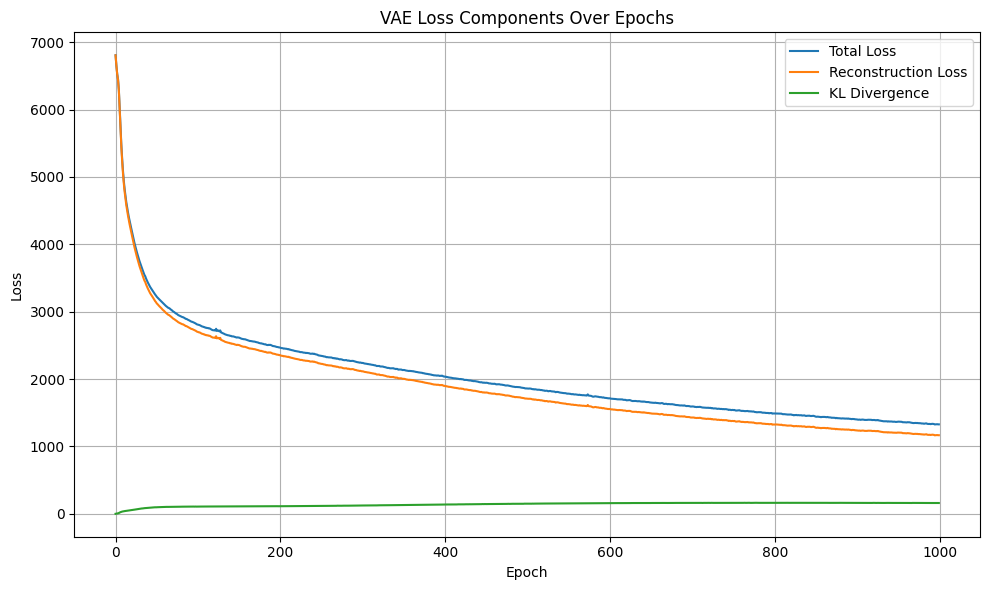

In [7]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

dim of latent mu: (331, 10)


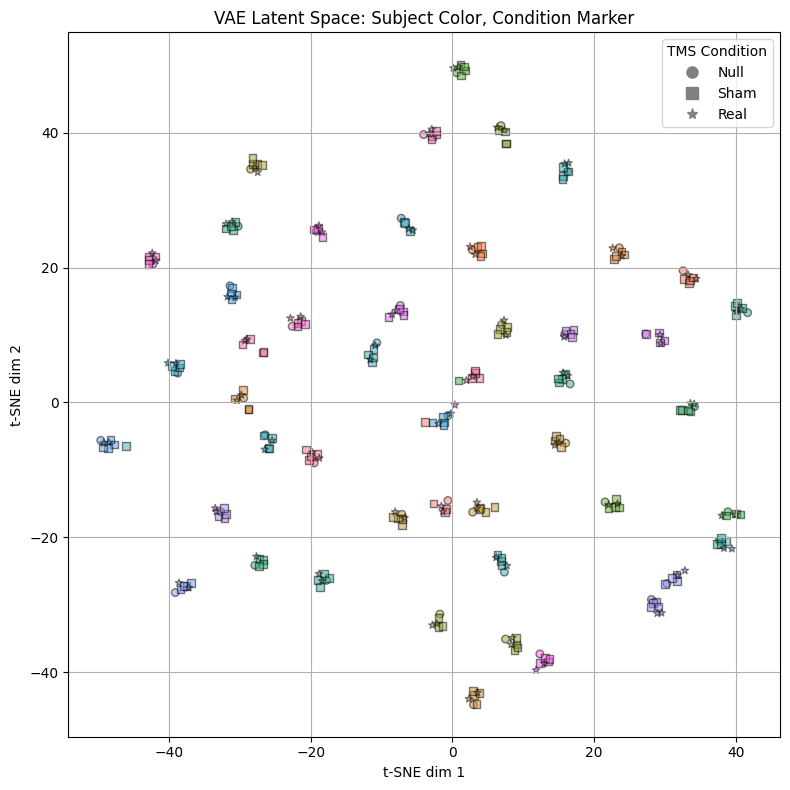

In [13]:
mu_all = get_latent_mu(model, X_tensor, device=DEVICE)

# plot 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

Paired t-test: t = -1.972, p = 0.0548


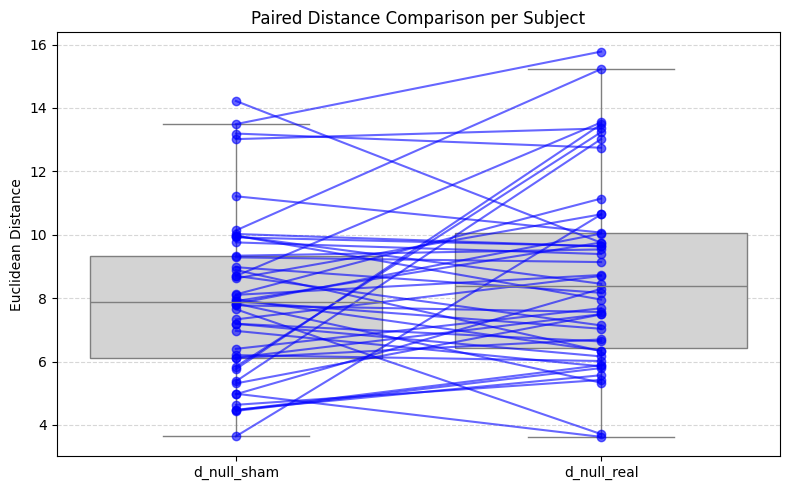

In [11]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)

# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)

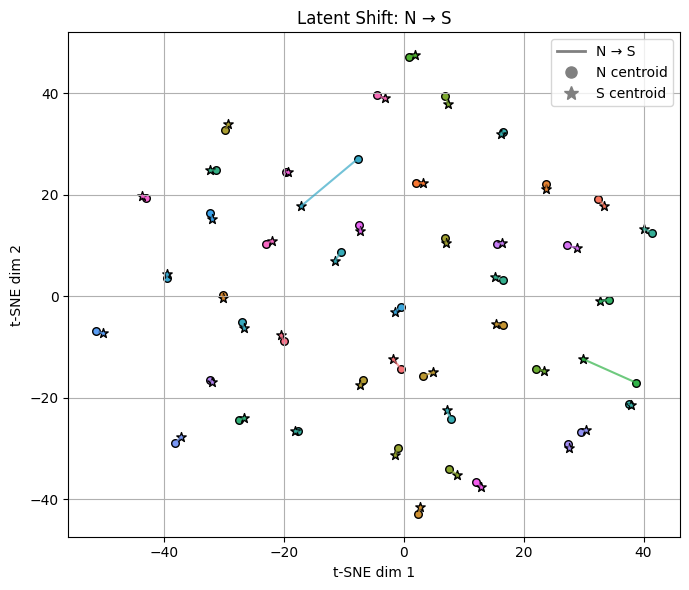

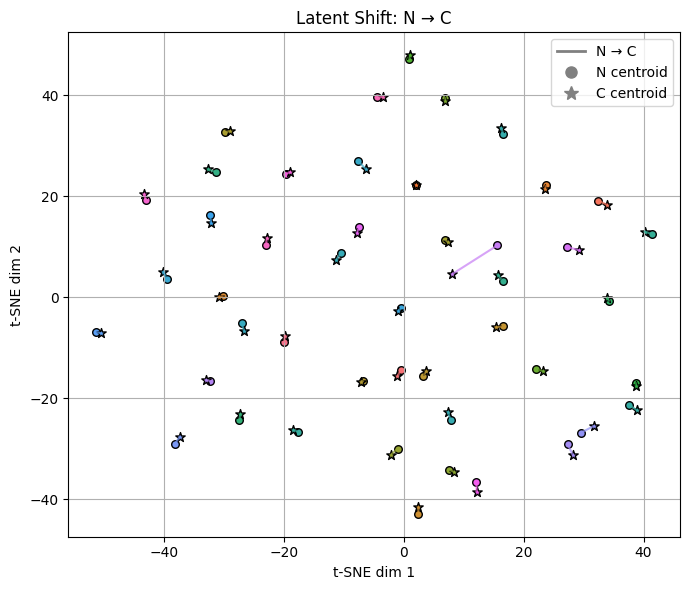

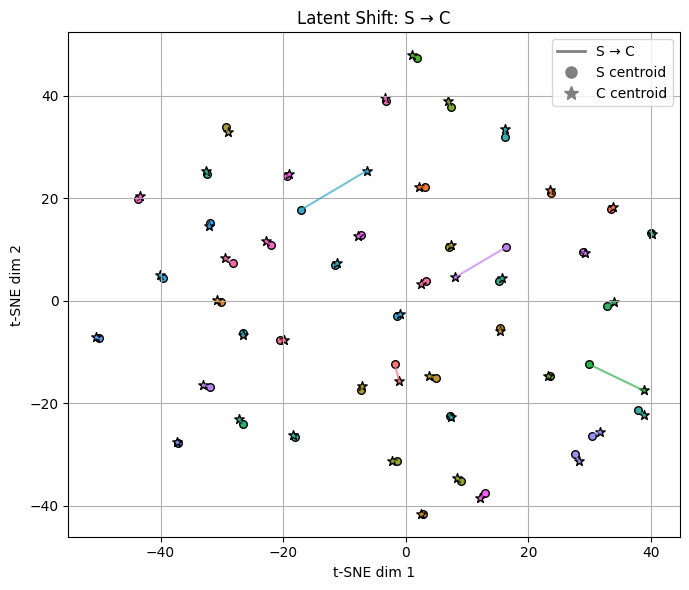

In [12]:
def plot_condition_shift(z_2d, all_tms_type, all_subject_id,
                         from_label='N', to_label='C',
                         label_map={'N': 0, 'S': 1, 'C': 2},
                         figsize=(7, 6),
                         title=None):
    """
    Plot centroid shift for a single condition contrast (e.g., Sham → Real).
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    y = np.array([label_map[t] for t in all_tms_type])
    unique_subjects = np.unique(all_subject_id)
    palette = sns.color_palette("husl", len(unique_subjects))
    subject_to_color = {subj: palette[i] for i, subj in enumerate(unique_subjects)}

    fig, ax = plt.subplots(figsize=figsize)

    for subj in unique_subjects:
        mask = np.array(all_subject_id) == subj
        subj_points = z_2d[mask]
        subj_labels = y[mask]

        if (label_map[from_label] not in subj_labels) or (label_map[to_label] not in subj_labels):
            continue  # skip if missing condition

        color = subject_to_color[subj]
        from_centroid = subj_points[subj_labels == label_map[from_label]].mean(axis=0)
        to_centroid = subj_points[subj_labels == label_map[to_label]].mean(axis=0)

        ax.plot(
            [from_centroid[0], to_centroid[0]],
            [from_centroid[1], to_centroid[1]],
            color=color, linestyle='-', linewidth=1.5, alpha=0.7
        )

        ax.scatter([from_centroid[0]], [from_centroid[1]], marker='o', color=color, s=30, edgecolor='black')
        ax.scatter([to_centroid[0]], [to_centroid[1]], marker='*', color=color, s=50, edgecolor='black')

    contrast_name = f"{from_label} → {to_label}"
    ax.set_title(title or f"Latent Shift: {contrast_name}")
    ax.set_xlabel('t-SNE dim 1')
    ax.set_ylabel('t-SNE dim 2')
    ax.grid(True)

    legend_elements = [
        Line2D([0], [0], linestyle='-', color='gray', lw=2, label=contrast_name),
        Line2D([0], [0], marker='o', color='gray', lw=0, markersize=8, label=f'{from_label} centroid'),
        Line2D([0], [0], marker='*', color='gray', lw=0, markersize=10, label=f'{to_label} centroid')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()


plot_condition_shift(z_2d, all_tms_type, all_subject_id, from_label='N', to_label='S')
plot_condition_shift(z_2d, all_tms_type, all_subject_id, from_label='N', to_label='C')
plot_condition_shift(z_2d, all_tms_type, all_subject_id, from_label='S', to_label='C')


In [56]:
df_session_dists = compute_per_session_dist_to_null(mu_all, all_subject_id, all_tms_type)
df_session_dists.head(10)

,subject,index,condition,distance_to_null
0,NODEAP_06,1,S,12.395501
1,NODEAP_06,2,S,13.554702
2,NODEAP_06,3,S,10.082585
3,NODEAP_06,4,C,13.599648
4,NODEAP_06,5,C,10.084601
5,NODEAP_06,6,S,12.733582
6,NODEAP_07,8,S,13.964909
7,NODEAP_07,9,S,13.812804
8,NODEAP_07,10,C,11.326782
9,NODEAP_07,11,S,35.919022


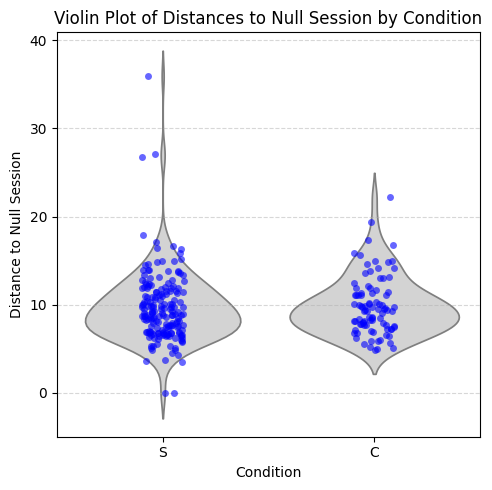

In [57]:
plt.figure(figsize=(5, 5))
sns.violinplot(data=df_session_dists, x='condition', y='distance_to_null', inner=None, color='lightgray')
sns.stripplot(data=df_session_dists, x='condition', y='distance_to_null',
              jitter=True, alpha=0.6, color='blue')

plt.title('Violin Plot of Distances to Null Session by Condition')
plt.ylabel('Distance to Null Session')
plt.xlabel('Condition')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
